In [3]:
library(ggthemes)
library(pryr)
library(tidyverse)
library(scater)
library(matrixStats)
library(ineq)

In [111]:
library(ggjoy)
library(mclust)

In [5]:
library(idcells)


Attaching package: ‘idcells’

The following object is masked from ‘package:ineq’:

    entropy



In [6]:
get_geneset_score <- function(object, geneset) {
    set_total <- colSums(counts(object)[fData(object)$hgnc_symbol %in% geneset,])
    set_total / object$total_counts
}

In [7]:
add_geneset_scores <- function(object, geneset_list) {
    for (i in seq_along(geneset_list))
        pData(object)[, names(geneset_list)[i]] <- get_geneset_score(object, geneset_list[[1]]@geneIds)
    object
}

In [8]:
library(scran)

Loading required package: BiocParallel


In [10]:
library(EnsDb.Mmusculus.v79)

## Load data

In [11]:
kolo_counts_raw <- read.delim("../../jamboree/kolodziejczyk_2015/counts/kolodziejczyk_salmon_counts_raw.tsv")

In [12]:
head(kolo_counts_raw)

ERR1211176 ERR1211177 ERR1211178 ERR1211179 ERR1211180
ENSMUSG00000000001  0          46         15          75       161       
ENSMUSG00000000003  0           0          0           0         0       
ENSMUSG00000000028 14         770        167        1141       428       
ENSMUSG00000000031  0           0          0           0         0       
ENSMUSG00000000037  0           0          0           0         0       
ENSMUSG00000000049  0           0          0           0         0       
                   ERR1211181 ERR1211182 ERR1211183 ERR1211184 ERR1211185 ⋯
ENSMUSG00000000001  81        991        1623       26         600        ⋯
ENSMUSG00000000003   0          0           0        0           0        ⋯
ENSMUSG00000000028 576        929         759        4         341        ⋯
ENSMUSG00000000031   0          0           0        0           0        ⋯
ENSMUSG00000000037  85          0           0        2           0        ⋯
ENSMUSG00000000049   0          0           0        0           0        ⋯
                   ERR523197 ERR523198 ERR523199 ERR523200 ERR523201 ERR523202
ENSMUSG00000000001 332       249       614       574       1134      1046     
ENSMUSG00000000003   0         0         0         0          0         0     
ENSMUSG00000000028 781       672       340       670        215         5     
ENSMUSG00000000031   0         0         0         0          0         0     
ENSMUSG00000000037   0         0         0         0          0         0     
ENSMUSG00000000049   0         0         0         0          0         0     
                   ERR523203 ERR523204 ERR523205 ERR523206
ENSMUSG00000000001 2426      1071      2668      259      
ENSMUSG00000000003    0         0         0        0      
ENSMUSG00000000028 5149       901       731      602      
ENSMUSG00000000031    0         0       170        0      
ENSMUSG00000000037    0         0         0        0      
ENSMUSG00000000049    0         0         0        0

In [13]:
dim(kolo_counts_raw)

[1] 43432   864

In [16]:
kolo_annos_raw <- read.delim("../../jamboree/kolodziejczyk_2015/counts/kolodziejczyk_annotation_raw.tsv")

In [17]:
head(kolo_annos_raw)

samples labels Extra sample_ID batch medium                 
1 2i_2_1  1      good  ERR523111 2i_2  standard 2i media + LIF
2 2i_2_10 1      good  ERR522883 2i_2  standard 2i media + LIF
3 2i_2_11 1      good  ERR522830 2i_2  standard 2i media + LIF
4 2i_2_12 1      good  ERR523005 2i_2  standard 2i media + LIF
5 2i_2_13 1      good  ERR523046 2i_2  standard 2i media + LIF
6 2i_2_14 1      good  ERR522906 2i_2  standard 2i media + LIF

In [18]:
dim(kolo_annos_raw)

[1] 864   6

In [19]:
dim(kolo_counts_raw)

[1] 43432   864

In [20]:
keytypes(EnsDb.Mmusculus.v79)

[1] "ENTREZID"        "EXONID"          "GENEBIOTYPE"     "GENEID"         
 [5] "GENENAME"        "PROTEINDOMAINID" "PROTEINID"       "SEQNAME"        
 [9] "SEQSTRAND"       "SYMBOL"          "TXBIOTYPE"       "TXID"           
[13] "TXNAME"          "UNIPROTID"

In [42]:
gsym <- mapIds(EnsDb.Mmusculus.v79, keys = rownames(kolo_counts_raw), 
              column = c("SYMBOL"), keytype="GENEID")
gbio <- mapIds(EnsDb.Mmusculus.v79, keys = rownames(kolo_counts_raw), 
              column = c("GENEBIOTYPE"), keytype="GENEID")
gchr <- mapIds(EnsDb.Mmusculus.v79, keys = rownames(kolo_counts_raw), 
              column = c("SEQNAME"), keytype="GENEID")
gstr <- mapIds(EnsDb.Mmusculus.v79, keys = rownames(kolo_counts_raw), 
              column = c("SEQSTRAND"), keytype="GENEID")
gnam <- mapIds(EnsDb.Mmusculus.v79, keys = rownames(kolo_counts_raw), 
              column = c("GENENAME"), keytype="GENEID")
feat_annos <- data_frame(ensembl_gene_id = rownames(kolo_counts_raw), 
                mgi_symbol = gsym, gene_biotype = gbio, 
                chrom = gchr, strand = gstr, gene_name = gnam)
head(feat_annos)

ensembl_gene_id    mgi_symbol gene_biotype   chrom strand gene_name
1 ENSMUSG00000000001 Gnai3      protein_coding 3     -1     Gnai3    
2 ENSMUSG00000000003 Pbsn       protein_coding X     -1     Pbsn     
3 ENSMUSG00000000028 Cdc45      protein_coding 16    -1     Cdc45    
4 ENSMUSG00000000031 H19        lincRNA        7     -1     H19      
5 ENSMUSG00000000037 Scml2      protein_coding X      1     Scml2    
6 ENSMUSG00000000049 Apoh       protein_coding 11     1     Apoh

In [23]:
dim(feat_annos)

[1] 43432     5

In [24]:
mem_used()

629 MB

In [25]:
pd <- as(as.data.frame(kolo_annos_raw), "AnnotatedDataFrame")
rownames(pd) <- kolo_annos_raw[["sample_ID"]]
fd <- as(as.data.frame(feat_annos), "AnnotatedDataFrame")
rownames(fd) <- feat_annos[["ensembl_gene_id"]]

In [26]:
all(rownames(pd) %in% colnames(as.matrix(kolo_counts_raw)))

[1] TRUE

In [27]:
mm <- match(colnames(as.matrix(kolo_counts_raw)), rownames(pd))
identical(colnames(as.matrix(kolo_counts_raw)), rownames(pd)[mm])

[1] TRUE

In [28]:
sce <- newSCESet(countData = as.matrix(kolo_counts_raw), phenoData = pd[mm,],
                 featureData = fd)
sce <- sce[rowSums(counts(sce)) > 0.5,]
sce

SCESet (storageMode: lockedEnvironment)
assayData: 36402 features, 864 samples 
  element names: counts, exprs 
protocolData: none
phenoData
  sampleNames: ERR1211176 ERR1211177 ... ERR523206 (864 total)
  varLabels: samples labels ... medium (6 total)
  varMetadata: labelDescription
featureData
  featureNames: ENSMUSG00000000001 ENSMUSG00000000003 ...
    ENSMUSG00000104526 (36402 total)
  fvarLabels: ensembl_gene_id mgi_symbol ... strand (5 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [48]:
mito <- readxl::read_xls("Mouse.MitoCarta2.0.xls", sheet = "A Mouse MitoCarta2.0")

In [49]:
head(mito)

TrainingDataset HumanOrthologGeneID MouseGeneID Symbol
1 Tmito             1537              66445       Cyc1  
2 Tmito             5160              18597       Pdha1 
3 Tmito              513              66043       Atp5d 
4 Tmito           122961              74316       Isca2 
5 Tmito             7384              22273       Uqcrc1
6 Tmito             5162              68263       Pdhb  
  Synonyms                                                            
1 2610002H19Rik|AA408921|Q9D0M3                                       
2 Pdha-1|P35486                                                       
3 0610008F14Rik|1500000I11Rik|AA960090|AI876556|AU020773|C85518|Q9D3D9
4 0710001C05Rik|5730594E03Rik|Hbld1|Q9DCB8                            
5 1110032G10Rik|Q9CZ13                                                
6 2610103L06Rik|AL024199|C81408|Q9D051                                
  Description                                                           
1 cytochrome c-1                                                        
2 pyruvate dehydrogenase E1 alpha 1                                     
3 ATP synthase, H+ transporting, mitochondrial F1 complex, delta subunit
4 iron-sulfur cluster assembly 2 homolog (S. cerevisiae)                
5 ubiquinol-cytochrome c reductase core protein 1                       
6 pyruvate dehydrogenase (lipoamide) beta                               
  EnsemblGeneID      ProteinLength TargetP_Score MitoDomain_Score ⋯
1 ENSMUSG00000022551 325           2             MitoDomain       ⋯
2 ENSMUSG00000031299 390           1             MitoDomain       ⋯
3 ENSMUSG00000003072 168           2             MitoDomain       ⋯
4 ENSMUSG00000021241 154           1             MitoDomain       ⋯
5 ENSMUSG00000025651 480           1             MitoDomain       ⋯
6 ENSMUSG00000021748 359           1             MitoDomain       ⋯
  liver_total_peak_intensity_log10 heart_total_peak_intensity_log10
1 10.0                             10.4                            
2  9.6                             10.5                            
3  9.8                              9.8                            
4  8.2                              7.9                            
5 10.0                             10.8                            
6  9.6                             10.5                            
  skeletalmuscle_total_peak_intensity_log10 adipose_total_peak_intensity_log10
1  9.8                                      10.1                              
2 10.0                                      10.1                              
3  9.5                                       9.8                              
4  7.2                                       8.7                              
5 10.3                                      10.1                              
6  9.8                                      10.4                              
  smallintestine_total_peak_intensity_log10
1 10.2                                     
2  9.9                                     
3 10.1                                     
4  8.5                                     
5 10.6                                     
6  9.8                                     
  largeintestine_total_peak_intensity_log10 stomach_total_peak_intensity_log10
1 10.2                                      10.0                              
2  9.6                                      10.0                              
3 10.0                                       9.8                              
4  8.4                                       8.0                              
5 10.2                                      10.3                              
6  9.9                                       9.9                              
  placenta_total_peak_intensity_log10 testis_total_peak_intensity_log10
1 10.0                                 9.8                             
2  9.9                                 8.9                             
3  9.8       

In [56]:
mtset <- (fData(sce)$mgi_symbol %in% 
    dplyr::filter(mito, grepl("Mitochondria", HPA_PrimarySubcellularLocalization_2015))[["Symbol"]])
sum(mtset)

[1] 349

In [57]:
sce <- calculateQCMetrics(sce, feature_controls = list(mt = mtset))
setSpike(sce) <- "mt"

In [162]:
head(fData(sce))

ensembl_gene_id    mgi_symbol gene_biotype   chrom strand
ENSMUSG00000000001 ENSMUSG00000000001 Gnai3      protein_coding 3     -1    
ENSMUSG00000000003 ENSMUSG00000000003 Pbsn       protein_coding X     -1    
ENSMUSG00000000028 ENSMUSG00000000028 Cdc45      protein_coding 16    -1    
ENSMUSG00000000031 ENSMUSG00000000031 H19        lincRNA        7     -1    
ENSMUSG00000000037 ENSMUSG00000000037 Scml2      protein_coding X      1    
ENSMUSG00000000049 ENSMUSG00000000049 Apoh       protein_coding 11     1    
                   mean_exprs exprs_rank n_cells_exprs total_feature_exprs
ENSMUSG00000000001 8.17014070 34604      838           7059.001568        
ENSMUSG00000000003 0.00246426  2302        2              2.129121        
ENSMUSG00000000028 7.65448959 34038      842           6613.479008        
ENSMUSG00000000031 0.65008556 20322      100            561.673924        
ENSMUSG00000000037 0.56097299 19738      120            484.680664        
ENSMUSG00000000049 0.01045723  6299        2              9.035043        
                   pct_total_exprs pct_dropout total_feature_counts
ENSMUSG00000000001 1.170905e-02     3.009259   589174.000          
ENSMUSG00000000003 3.531657e-06    99.768519        2.000          
ENSMUSG00000000028 1.097004e-02     2.546296   472626.999          
ENSMUSG00000000031 9.316708e-04    88.425926    54603.929          
ENSMUSG00000000037 8.039590e-04    86.111111     7039.001          
ENSMUSG00000000049 1.498678e-05    99.768519       52.000          
                   log10_total_feature_counts pct_total_counts
ENSMUSG00000000001 5.7702443                  1.399968e-02    
ENSMUSG00000000003 0.4771213                  4.752307e-08    
ENSMUSG00000000028 5.6745194                  1.123034e-02    
ENSMUSG00000000031 4.7372318                  1.297473e-03    
ENSMUSG00000000037 3.8475727                  1.672575e-04    
ENSMUSG00000000049 1.7242759                  1.235600e-06    
                   is_feature_control_ercc is_feature_spike
ENSMUSG00000000001 FALSE                   FALSE           
ENSMUSG00000000003 FALSE                   FALSE           
ENSMUSG00000000028 FALSE                   FALSE           
ENSMUSG00000000031 FALSE                   FALSE           
ENSMUSG00000000037 FALSE                   FALSE           
ENSMUSG00000000049 FALSE                   FALSE           
                   is_feature_control_mt is_feature_control hgnc_symbol
ENSMUSG00000000001 FALSE                 FALSE              GNAI3      
ENSMUSG00000000003 FALSE                 FALSE              NA         
ENSMUSG00000000028 FALSE                 FALSE              CDC45      
ENSMUSG00000000031 FALSE                 FALSE              NA         
ENSMUSG00000000037 FALSE                 FALSE              SCML2      
ENSMUSG00000000049 FALSE                 FALSE              APOH

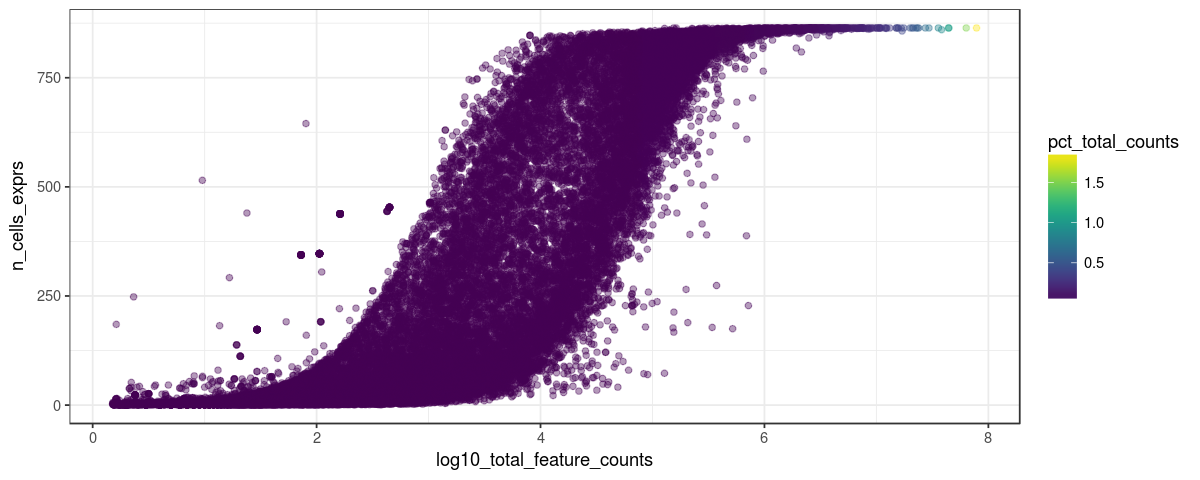

In [163]:
options(repr.plot.width = 10, repr.plot.height=4)
ggplot(fData(sce), aes(x = log10_total_feature_counts, y = n_cells_exprs, colour = pct_total_counts)) +
    geom_point(alpha = 0.4) +
    theme_bw() + viridis::scale_color_viridis()

In [171]:
sum(fData(sce)$n_cells_exprs > 0.9 * ncol(sce))

[1] 6044

In [172]:
ubiq_genes <- featureNames(sce)[fData(sce)$n_cells_exprs > 0.9 * ncol(sce)]

In [173]:
nonubiq_genes <- featureNames(sce)[fData(sce)$n_cells_exprs < 0.5 * ncol(sce)]

In [169]:
sce$ubiq_gene_score <- colSums(counts(sce)[ubiq_genes,]) / sce$total_counts

In [175]:
sce$nonubiq_gene_score <- colSums(counts(sce)[nonubiq_genes,]) / sce$total_counts

In [165]:
dim(sce)

Features  Samples 
   36402      864

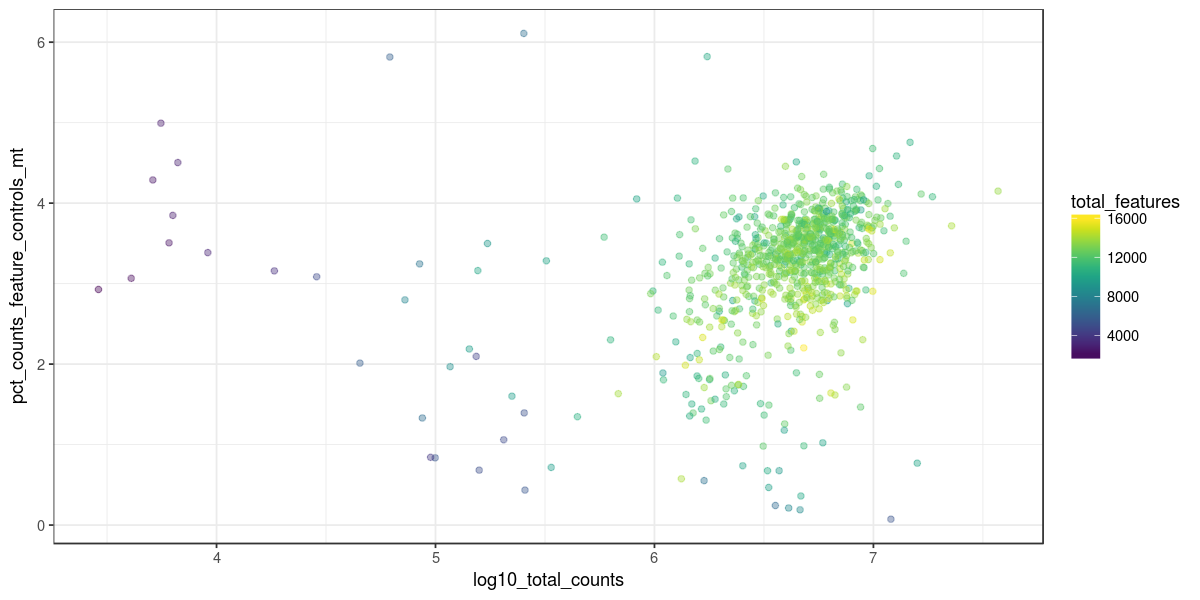

In [58]:
options(repr.plot.width = 10, repr.plot.height=5)
ggplot(pData(sce), aes(x = log10_total_counts, y = pct_counts_feature_controls_mt, colour = total_features)) +
    geom_point(alpha = 0.4) +
    theme_bw() + viridis::scale_color_viridis()


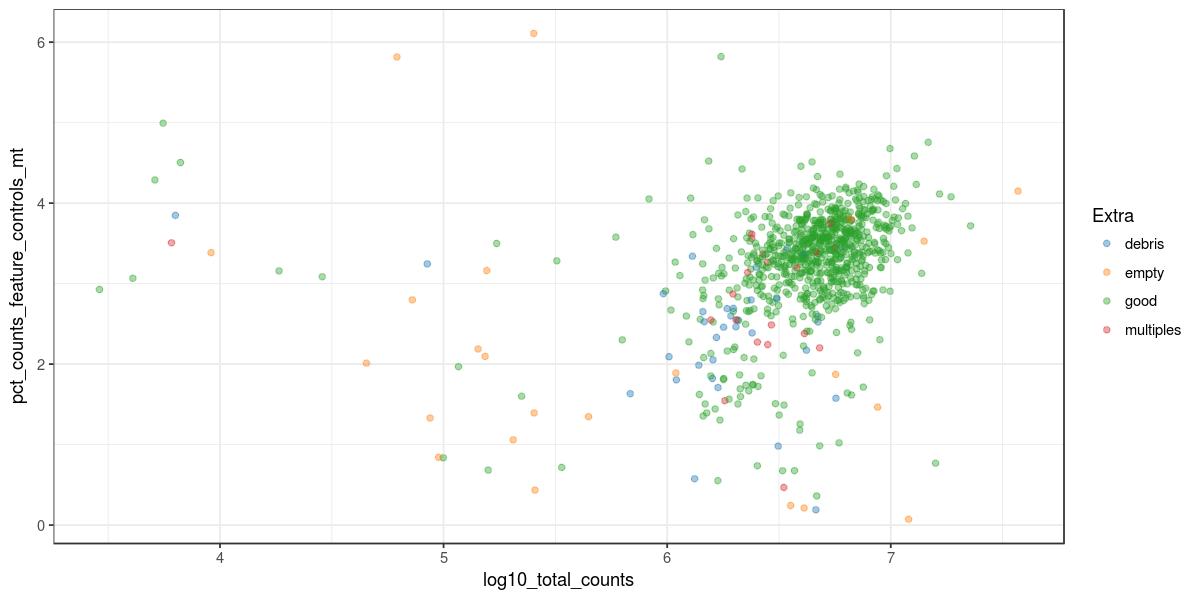

In [59]:
options(repr.plot.width = 10, repr.plot.height=5)
ggplot(pData(sce), aes(x = log10_total_counts, y = pct_counts_feature_controls_mt, colour = Extra)) +
    geom_point(alpha = 0.4) +
    theme_bw() + scale_color_tableau()


In [60]:
housekeeping_genes <- c("C1orf43", "CHMP2A", "EMC7", "GPI", "PSMB2", "PSMB4", "RAB7A", "REEP5", 
                        "SNRPD3", "VCP", "VPS29")

In [61]:
hallmark_genesets <- GSEABase::getGmt("msigdb/h.all.v6.0.symbols.gmt")

In [62]:
kegg_genesets <- GSEABase::getGmt("msigdb/c2.cp.kegg.v6.0.symbols.gmt")

In [63]:
hallmark_genesets

GeneSetCollection
  names: HALLMARK_TNFA_SIGNALING_VIA_NFKB, HALLMARK_HYPOXIA, ..., HALLMARK_PANCREAS_BETA_CELLS (50 total)
  unique identifiers: JUNB, CXCL2, ..., SRP14 (4386 total)
  types in collection:
    geneIdType: NullIdentifier (1 total)
    collectionType: NullCollection (1 total)

Convert genesets to mouse gene symbols.

In [64]:
library(biomaRt)

In [65]:
mart <- useMart("ensembl", dataset="hsapiens_gene_ensembl")

In [66]:
human <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse <- useMart("ensembl", dataset = "mmusculus_gene_ensembl")
genesV2 <- getLDS(attributes = c("mgi_symbol"), filters = "mgi_symbol", 
                 values = fData(sce)$mgi_symbol, mart = mouse, 
                 attributesL = c("hgnc_symbol"), martL = human, uniqueRows=TRUE)

genesV2 <- genesV2[genesV2[, 1] %in% fData(sce)$mgi_symbol,]
genesV2 <- genesV2[!duplicated(genesV2[, 1]),]

fData(sce)$hgnc_symbol <- NA

mm <- match(genesV2[, 1], fData(sce)$mgi_symbol)
mm <- mm[!is.na(mm)]

fData(sce)$hgnc_symbol[mm] <- genesV2[, 2]

In [67]:
tail(fData(sce))

ensembl_gene_id    mgi_symbol    gene_biotype chrom strand
ENSMUSG00000104519 ENSMUSG00000104519 RP23-462P13.1 TEC          1     -1    
ENSMUSG00000104520 ENSMUSG00000104520 RP23-226J18.4 lincRNA      1     -1    
ENSMUSG00000104523 ENSMUSG00000104523 RP24-424K5.5  antisense    1     -1    
ENSMUSG00000104524 ENSMUSG00000104524 RP24-331B5.1  TEC          1     -1    
ENSMUSG00000104525 ENSMUSG00000104525 RP23-445K23.3 TEC          1      1    
ENSMUSG00000104526 ENSMUSG00000104526 RP23-382I12.1 TEC          4      1    
                   mean_exprs exprs_rank n_cells_exprs total_feature_exprs
ENSMUSG00000104519 0.01148428  6576        6              9.922419        
ENSMUSG00000104520 0.77348652 20976      311            668.292349        
ENSMUSG00000104523 1.78524213 24639      481           1542.449199        
ENSMUSG00000104524 0.65235433 20333      143            563.634144        
ENSMUSG00000104525 0.84320831 21346      340            728.531983        
ENSMUSG00000104526 0.02922984  9602       18             25.254581        
                   pct_total_exprs pct_dropout total_feature_counts
ENSMUSG00000104519 1.645871e-05    99.30556      11.00000          
ENSMUSG00000104520 1.108523e-03    64.00463    1755.32957          
ENSMUSG00000104523 2.558522e-03    44.32870    6897.42834          
ENSMUSG00000104524 9.349223e-04    83.44907    4273.00000          
ENSMUSG00000104525 1.208445e-03    60.64815    5674.00000          
ENSMUSG00000104526 4.189077e-05    97.91667      32.20475          
                   log10_total_feature_counts pct_total_counts
ENSMUSG00000104519 1.079181                   2.613769e-07    
ENSMUSG00000104520 3.244606                   4.170932e-05    
ENSMUSG00000104523 3.838750                   1.638935e-04    
ENSMUSG00000104524 3.630835                   1.015330e-04    
ENSMUSG00000104525 3.753966                   1.348229e-04    
ENSMUSG00000104526 1.521200                   7.652342e-07    
                   is_feature_control_ercc is_feature_spike
ENSMUSG00000104519 FALSE                   FALSE           
ENSMUSG00000104520 FALSE                   FALSE           
ENSMUSG00000104523 FALSE                   FALSE           
ENSMUSG00000104524 FALSE                   FALSE           
ENSMUSG00000104525 FALSE                   FALSE           
ENSMUSG00000104526 FALSE                   FALSE           
                   is_feature_control_mt is_feature_control hgnc_symbol
ENSMUSG00000104519 FALSE                 FALSE              NA         
ENSMUSG00000104520 FALSE                 FALSE              NA         
ENSMUSG00000104523 FALSE                 FALSE              NA         
ENSMUSG00000104524 FALSE                 FALSE              NA         
ENSMUSG00000104525 FALSE                 FALSE              NA         
ENSMUSG00000104526 FALSE                 FALSE              NA

In [68]:
sce$ribo_score <- get_geneset_score(sce, fData(sce)$hgnc_symbol[grepl("^RP", fData(sce)$mgi_symbol)])

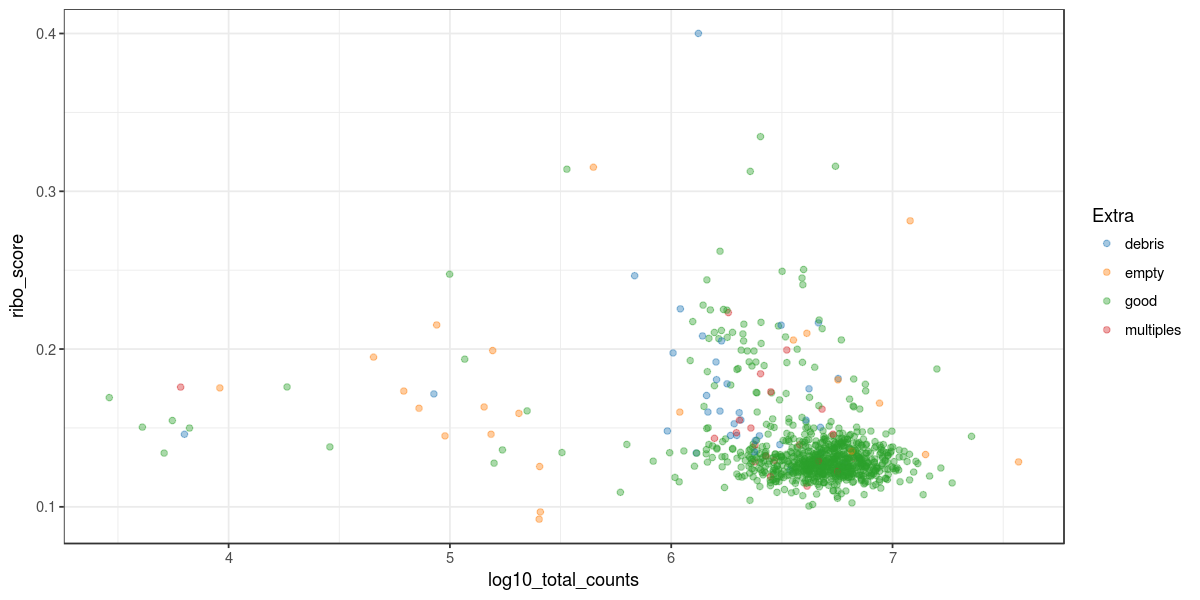

In [77]:
options(repr.plot.width = 10, repr.plot.height=5)
ggplot(pData(sce), aes(x = log10_total_counts, y = ribo_score, colour = Extra)) +
    geom_point(alpha = 0.4) +
    theme_bw() + scale_color_tableau()


In [71]:
sce$housekeeping_score <- get_geneset_score(sce, housekeeping_genes)

In [73]:
sce <- add_geneset_scores(sce, hallmark_genesets)

In [74]:
sce <- add_geneset_scores(sce, kegg_genesets)

In [81]:
#qc <- quickCluster(sce)
#sce <- computeSumFactors(sce, clusters = qc)

Warning message in .computeSumFactors(assayDataElement(x, assay), subset.row = subset.row, :
"encountered negative factor estimates"

In [83]:
#sce <- computeSpikeFactors(sce)

Warning message in .local(x, ...):
"zero spike-in counts during spike-in normalization"

In [75]:
saveRDS(sce, "sceset_kolo.rds")

In [109]:
write_tsv(pData(sce), "davis_kolo_cell_scores.tsv")

In [79]:
grep( "ribo", varLabels(sce),)

[1] 46

In [80]:
ncol(pData(sce))

[1] 283

### with all annotated gene sets

In [83]:
selected_vars <- c('log10_total_counts', 'log10_total_features', 
                   'pct_counts_feature_controls_mt', 'n_detected_feature_controls_mt', 
                   'pct_counts_top_500_features', 'pct_counts_top_50_endogenous_features', 
                   'pct_counts_top_500_endogenous_features', 'log10_counts_feature_controls_mt',
                    'log10_counts_endogenous_features', varLabels(sce)[46:283])

In [84]:
pdata_pca <- prcomp(pData(sce)[, selected_vars], scale. = TRUE)

In [85]:
reducedDimension(sce) <- pdata_pca$x[, 1:30]

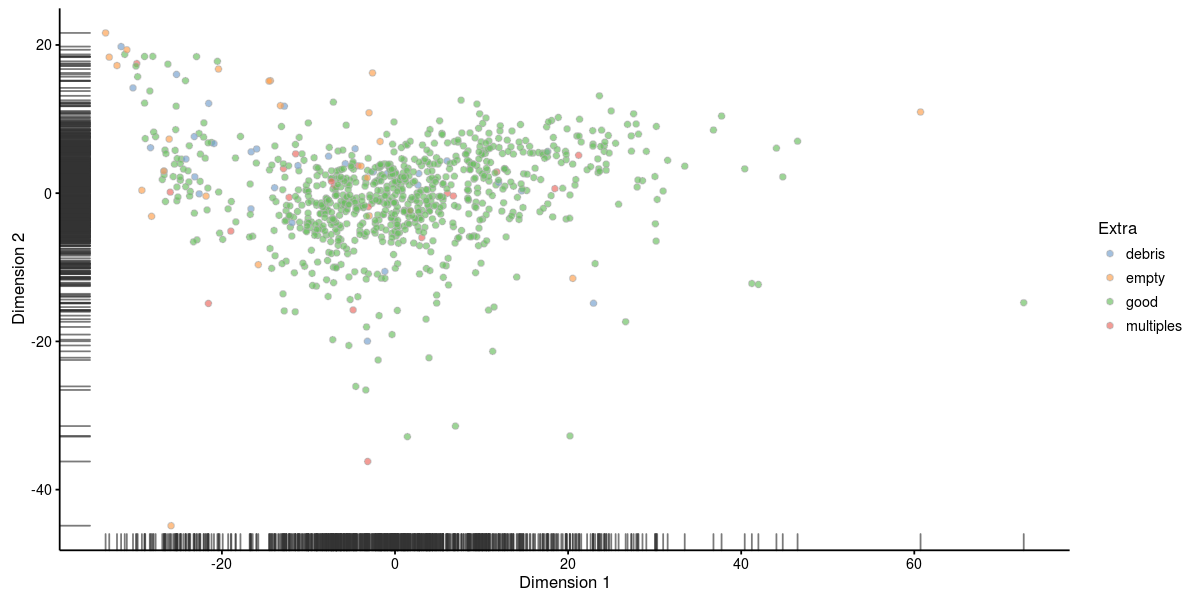

In [86]:
plotReducedDim(sce, colour_by = "Extra")

### with fewer genesets

In [87]:
grep("APOP", varLabels(sce))

[1]  57 200

In [129]:
selected_vars2 <- c('log10_total_counts', 'log10_total_features', 
                   'pct_counts_feature_controls_mt',  
                   'pct_counts_top_500_features', 'log10_counts_feature_controls_mt', 
                    'ribo_score', 'housekeeping_score',
                   varLabels(sce)[c(grep("APOP", varLabels(sce)))])

In [130]:
pdata_pca2 <- prcomp(pData(sce)[, selected_vars2], scale. = TRUE)

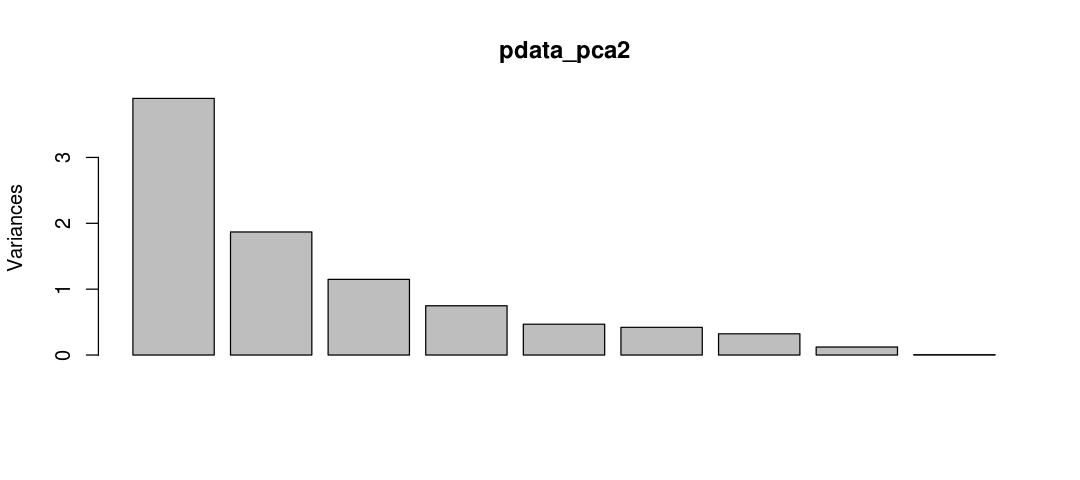

In [131]:
plot(pdata_pca2)

In [132]:
pdata_pca2$rotation

PC1        PC2        PC3         PC4        
log10_total_counts                0.3640426 -0.4493887  0.10661244 -0.04981998
log10_total_features              0.3262253 -0.4636455 -0.04534493 -0.21228256
pct_counts_feature_controls_mt    0.3614846  0.3054170  0.13227164  0.39207360
pct_counts_top_500_features      -0.4156603 -0.1211859  0.22712546  0.06409988
log10_counts_feature_controls_mt  0.4431253 -0.3027890  0.10020369  0.03685097
ribo_score                       -0.3810873 -0.2816240  0.20170229 -0.08380814
housekeeping_score                0.1138912  0.3005269  0.54804446 -0.75053597
HALLMARK_APOPTOSIS                0.1636529  0.2936303 -0.65887798 -0.39028283
KEGG_APOPTOSIS                    0.2761601  0.3571954  0.36372838  0.26573832
                                 PC5          PC6         PC7         
log10_total_counts               -0.345757548 -0.23628427  0.005686943
log10_total_features              0.192074752  0.44052263  0.014245137
pct_counts_feature_controls_mt    0.258336439 -0.33099028 -0.529272829
pct_counts_top_500_features      -0.574873401 -0.32175095  0.005872244
log10_counts_feature_controls_mt -0.173407863 -0.23945822 -0.137050062
ribo_score                        0.005781907  0.30790141 -0.763704121
housekeeping_score                0.096461938 -0.15172745 -0.008368638
HALLMARK_APOPTOSIS               -0.423293569  0.01766544 -0.339419027
KEGG_APOPTOSIS                   -0.477237672  0.60129403  0.047942781
                                 PC8         PC9          
log10_total_counts                0.28355430 -0.6291745666
log10_total_features             -0.63215516 -0.0267185612
pct_counts_feature_controls_mt   -0.33462741 -0.1908777785
pct_counts_top_500_features      -0.56479915  0.0617255415
log10_counts_feature_controls_mt  0.17682843  0.7503988362
ribo_score                        0.22283969 -0.0038167625
housekeeping_score               -0.02536254 -0.0039941041
HALLMARK_APOPTOSIS               -0.07623108 -0.0072178386
KEGG_APOPTOSIS                    0.04028616  0.0002885262

In [134]:
reducedDimension(sce) <- pdata_pca2$x[, 1:4]

In [135]:
plotReducedDim(sce, ncomponents = 2, colour_by = "Extra")

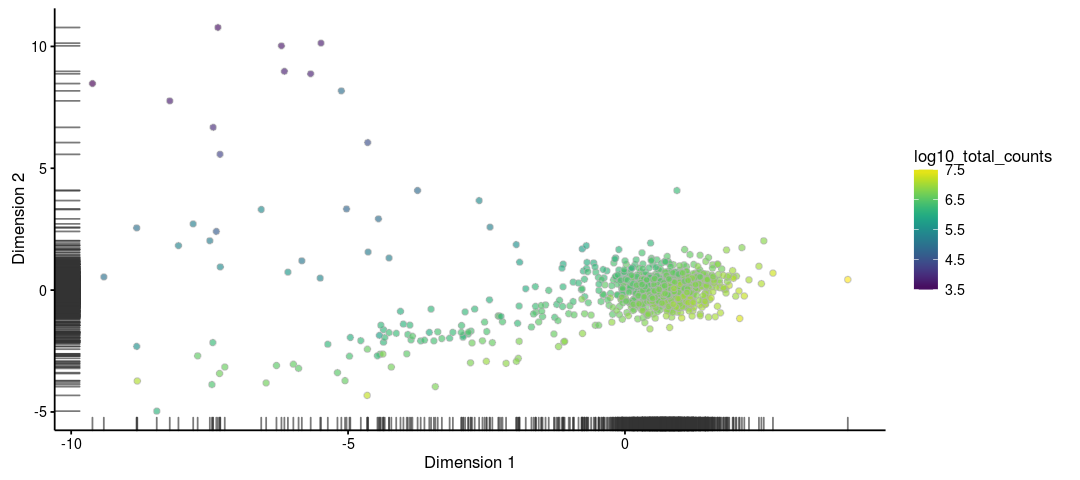

In [136]:
plotReducedDim(sce, ncomponents = 2, colour_by = "log10_total_counts")

In [157]:
m0 <- Mclust(sce$log10_total_counts)

In [158]:
m0

'Mclust' model object:
 best model: univariate, unequal variance (V) with 3 components

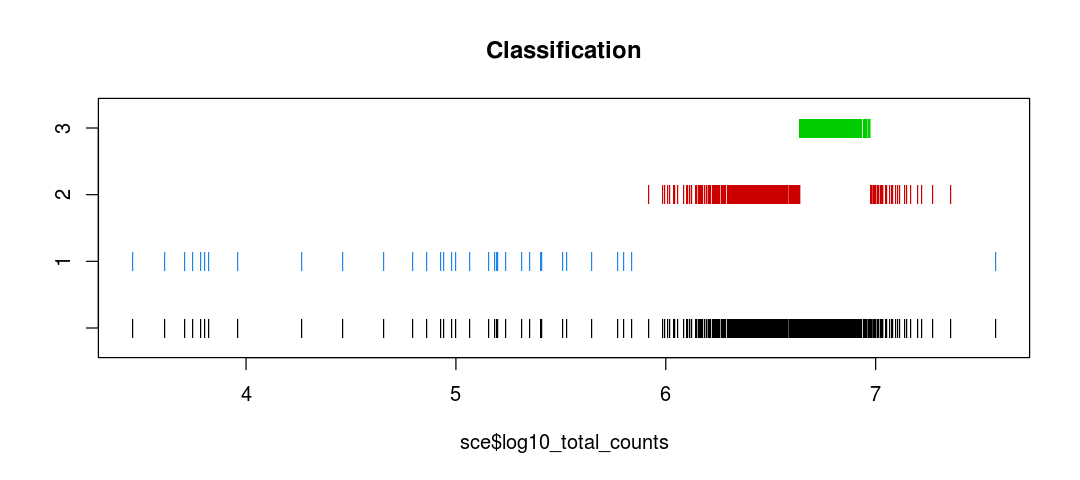

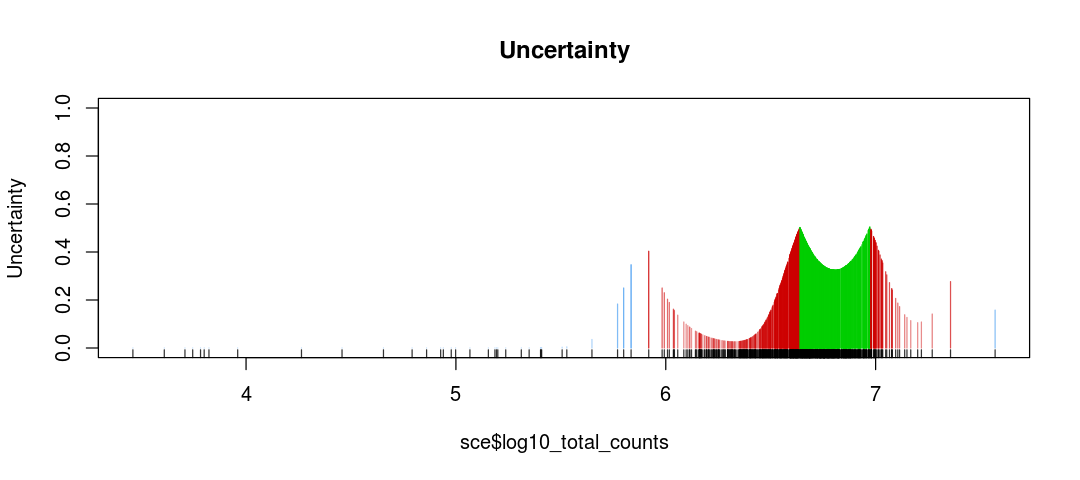

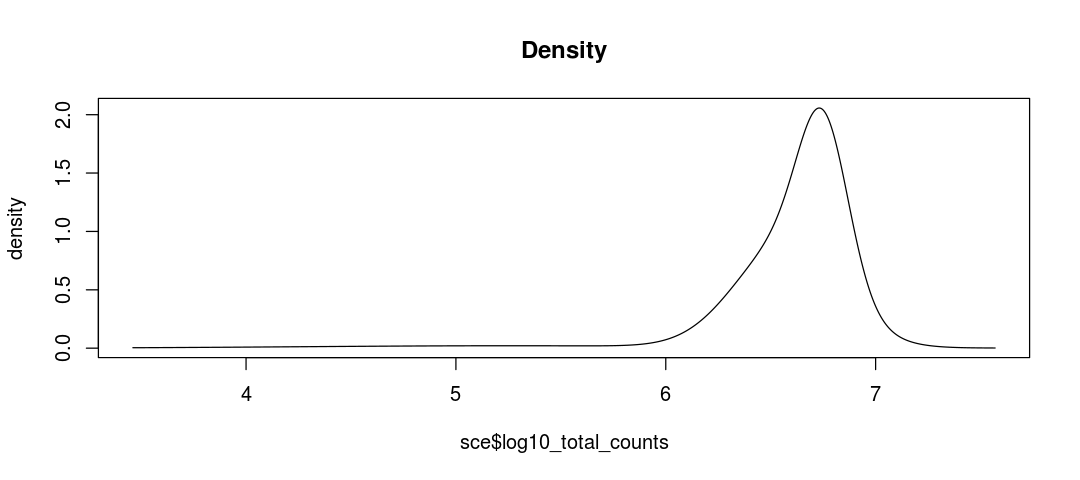

In [159]:
plot(m0)

In [160]:
sce$mclust_totalcounts_class <- as.factor(m0$classification)

Picking joint bandwidth of 0.159


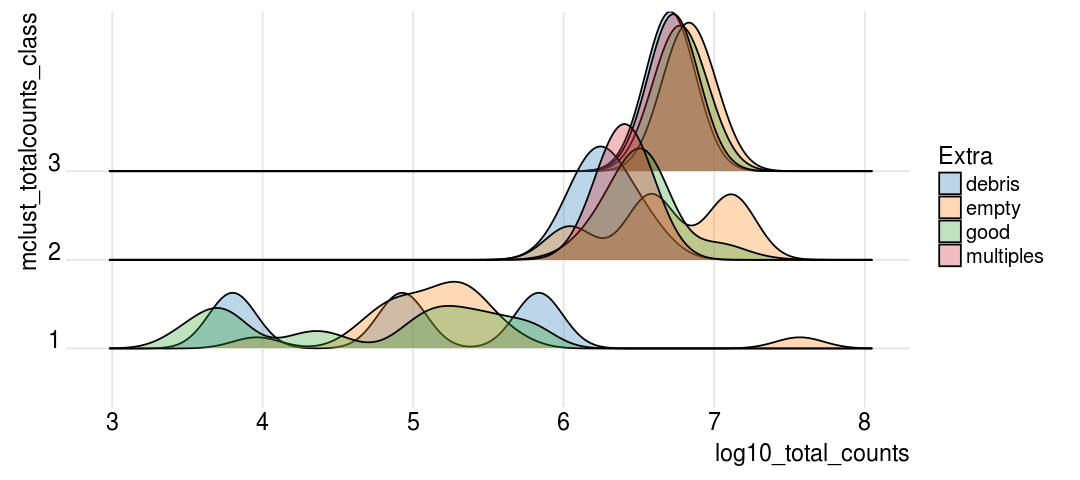

In [161]:
options(repr.plot.width = 9, repr.plot.height = 4)
ggplot(pData(sce), aes(x = log10_total_counts, y = mclust_totalcounts_class, fill = Extra)) +
    geom_joy(alpha = 0.3) + scale_fill_tableau() + theme_joy()

In [137]:
m1 <- Mclust(redDim(sce)[, 1:2])

In [138]:
m1

'Mclust' model object:
 best model: ellipsoidal, equal orientation (VVE) with 3 components

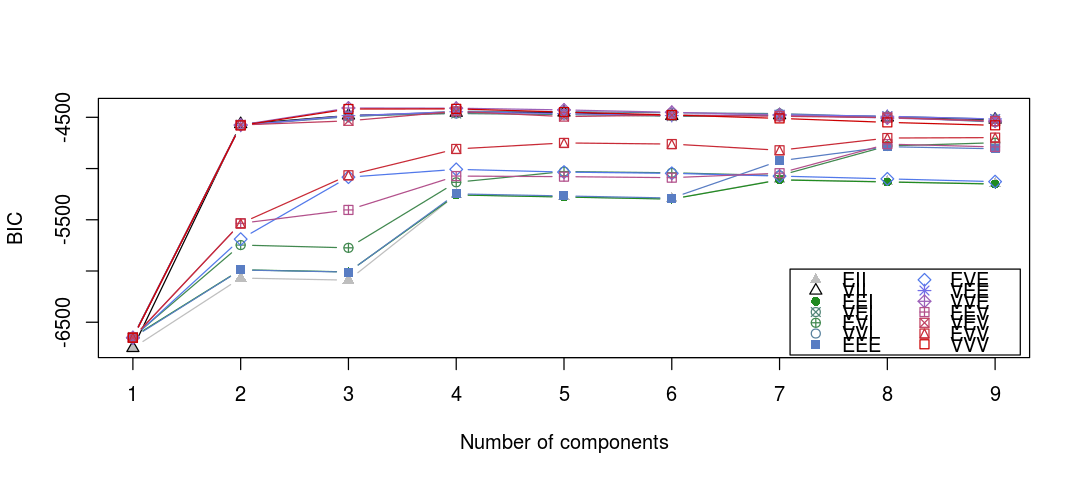

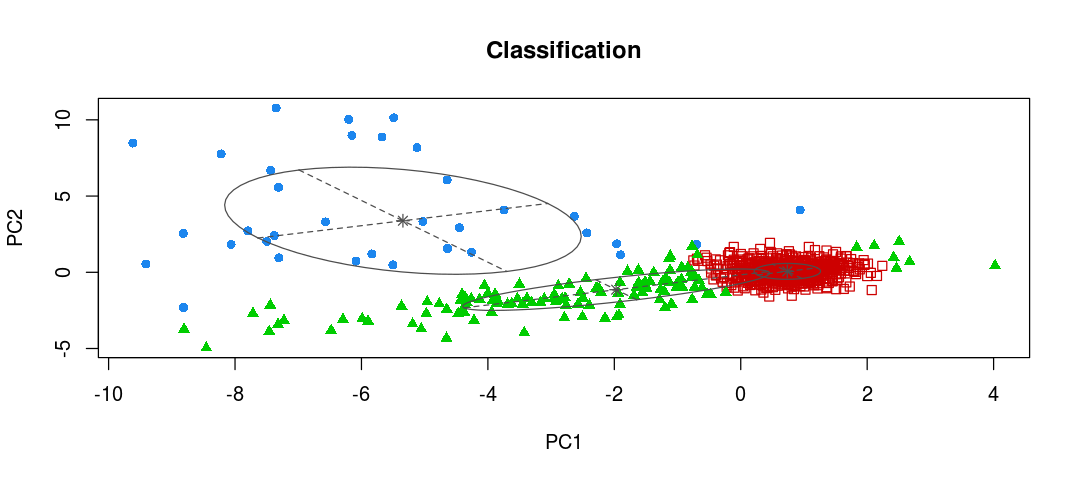

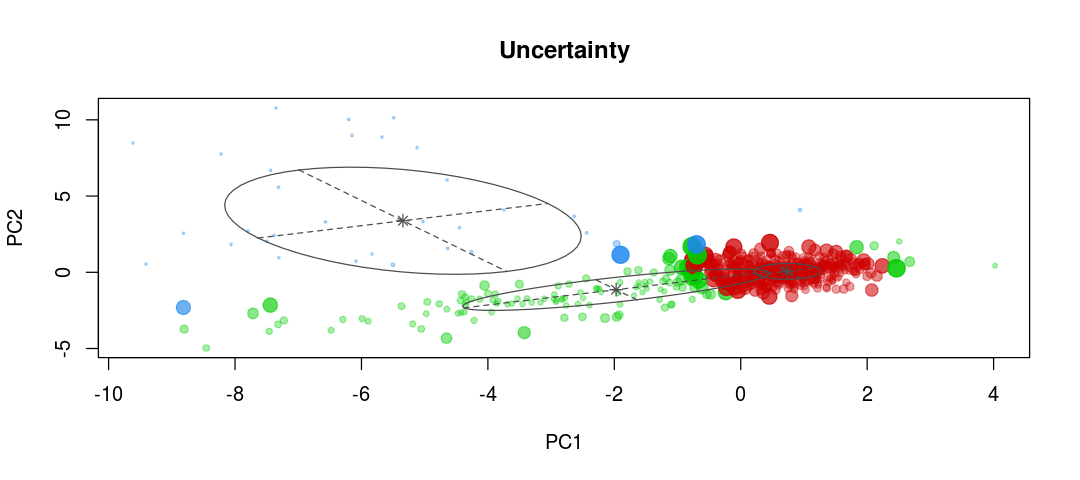

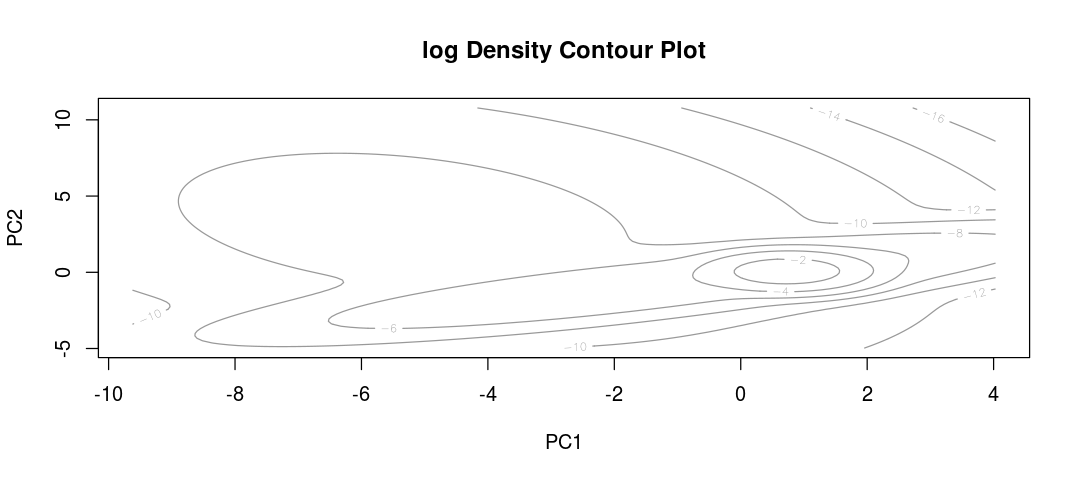

In [140]:
plot(m1)

In [141]:
sce$mclust_2pcs_class <- as.factor(m1$classification)

In [142]:
options(repr.plot.width = 9, repr.plot.height = 6)
ggplot(pData(sce), aes(x = log10_total_counts, y = mclust_2pcs_class, fill = Extra)) +
    geom_joy(alpha = 0.3) + scale_fill_tableau() + theme_joy()

Picking joint bandwidth of 0.163


In [143]:
m2 <- Mclust(pData(sce)[, selected_vars2])

In [144]:
m2

'Mclust' model object:
 best model: ellipsoidal, varying volume, shape, and orientation (VVV) with 6 components

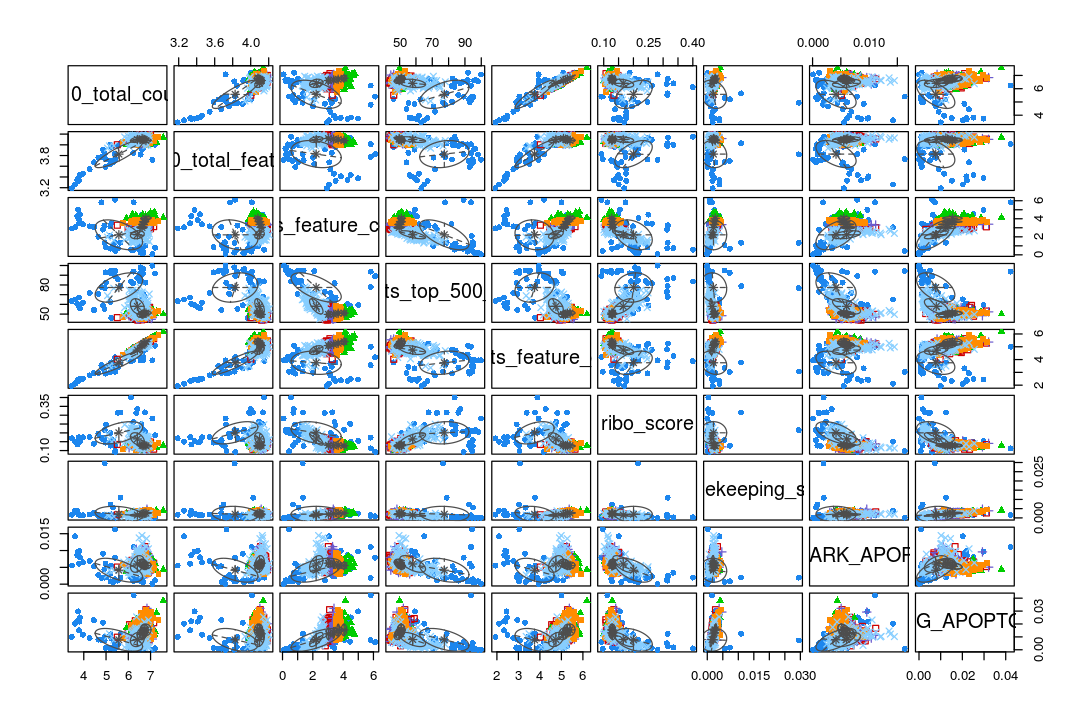

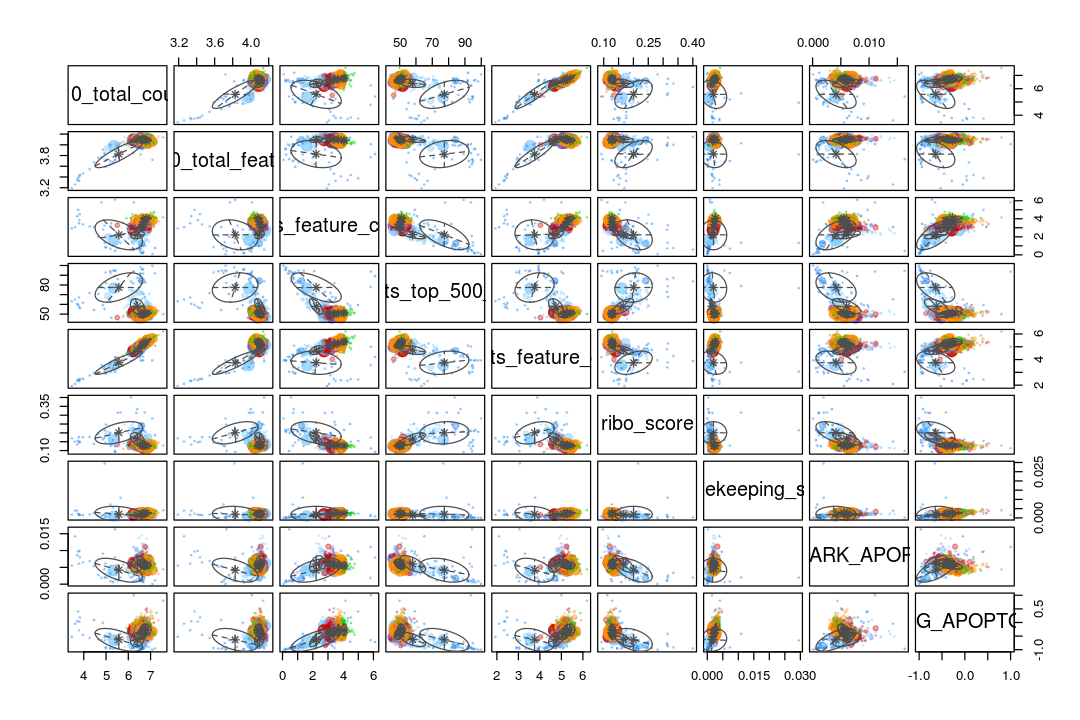

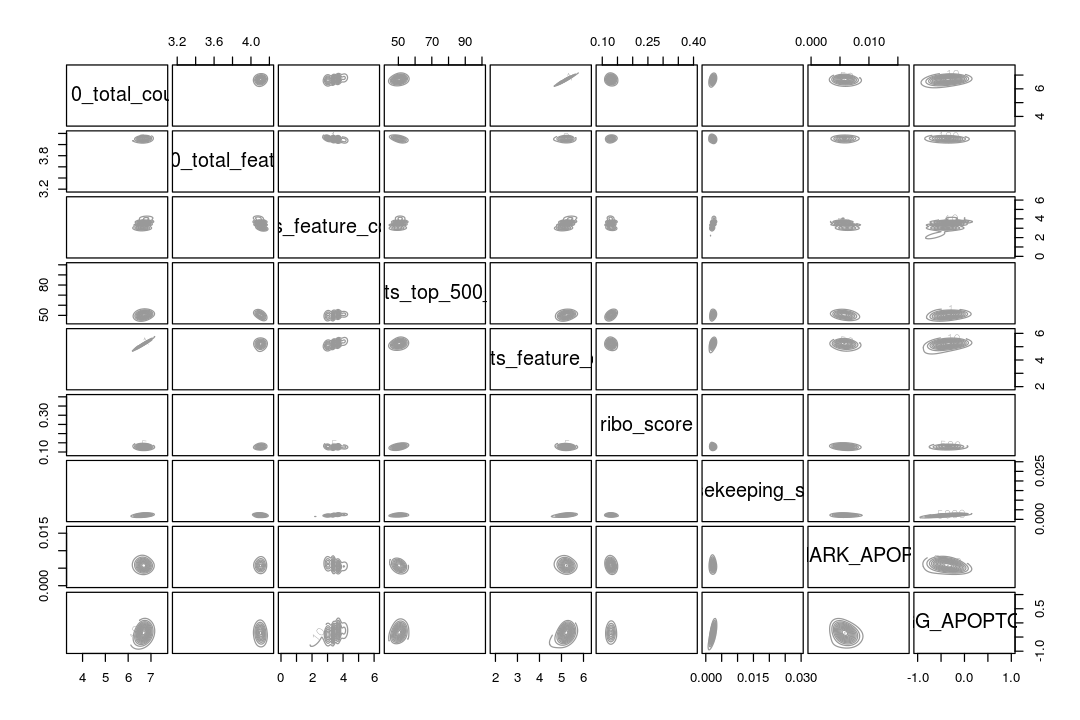

In [145]:
plot(m2)

In [146]:
sce$mclust_metrics_class <- as.factor(m2$classification)

Picking joint bandwidth of 0.215


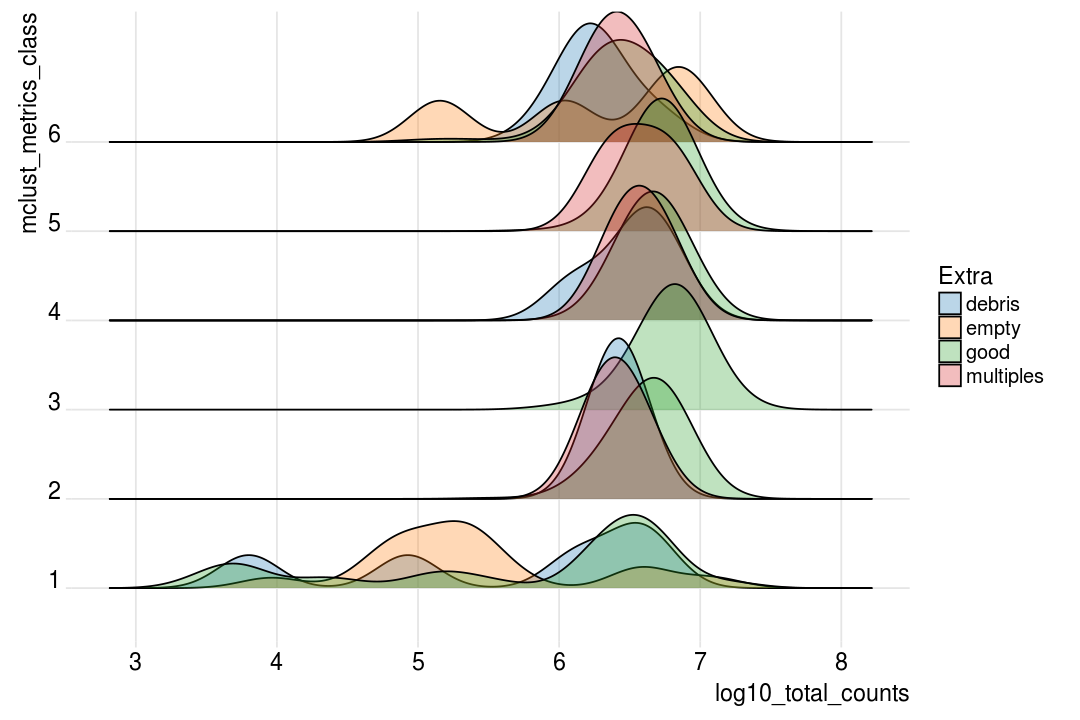

In [147]:
options(repr.plot.width = 9, repr.plot.height = 6)
ggplot(pData(sce), aes(x = log10_total_counts, y = mclust_metrics_class, fill = Extra)) +
    geom_joy(alpha = 0.3) + scale_fill_tableau() + theme_joy()

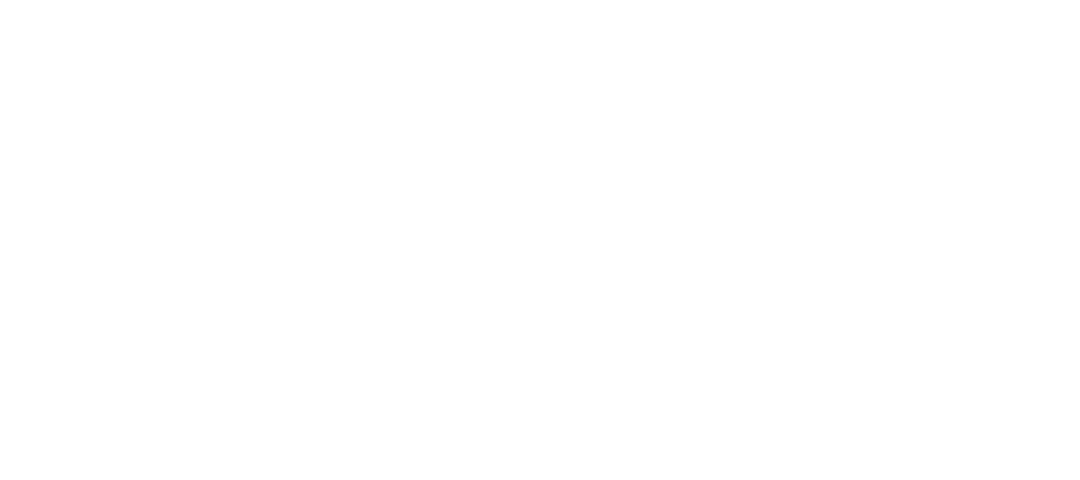

In [128]:
options(repr.plot.width = 9, repr.plot.height = 4)
ggplot(pData(sce), aes(x = mclust_metrics_class, fill = Extra)) +
    geom_histogram(alpha = 0.3) + scale_fill_tableau() + theme_joy()

In [98]:
redDim(sce)[1:6, 1:5]

PC1          PC2        PC3       PC4        PC5        
ERR1211176 -3.267082141 -2.3405395 0.7117638 -0.5966007 -0.10737378
ERR1211177  0.661401600  0.8417660 1.4339951 -1.0974216  1.25422231
ERR1211178 -3.383278467 -2.3799453 1.5353997 -1.2497152 -0.29131822
ERR1211179  0.007031894 -0.1089256 1.0165276  0.5575192 -0.01529624
ERR1211180  0.783546919  0.9626996 1.1486883 -0.2308398 -0.21154652
ERR1211181 -0.677526046  0.2896701 1.4360438 -0.6569861 -0.63397768

Picking joint bandwidth of 0.816


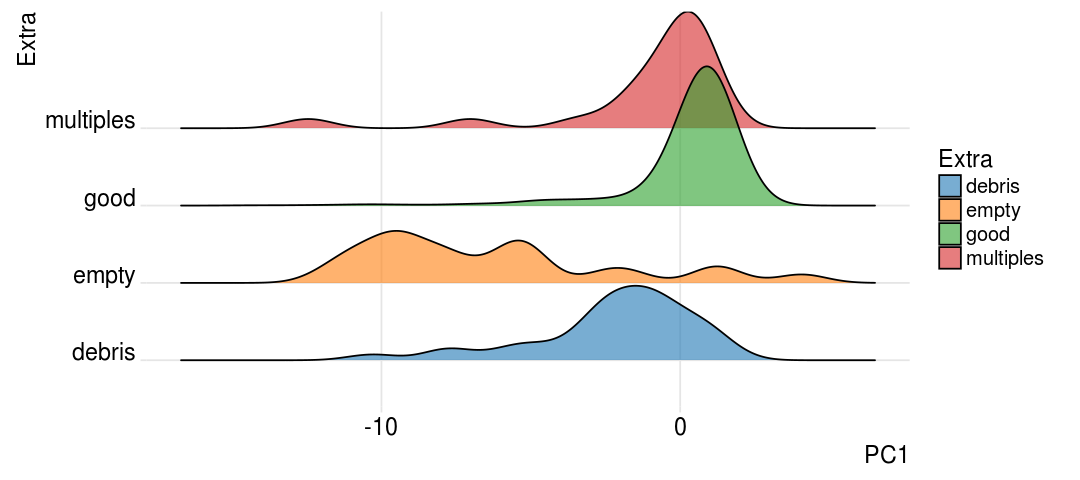

In [99]:
options(repr.plot.width=9, repr.plot.height=4)
bind_cols(pData(sce), as_data_frame(redDim(sce))) %>%
    ggplot(aes(x = PC1, y = Extra, fill = Extra)) +
        geom_joy(alpha = 0.6) + theme_joy() + scale_fill_tableau()

Picking joint bandwidth of 0.0149


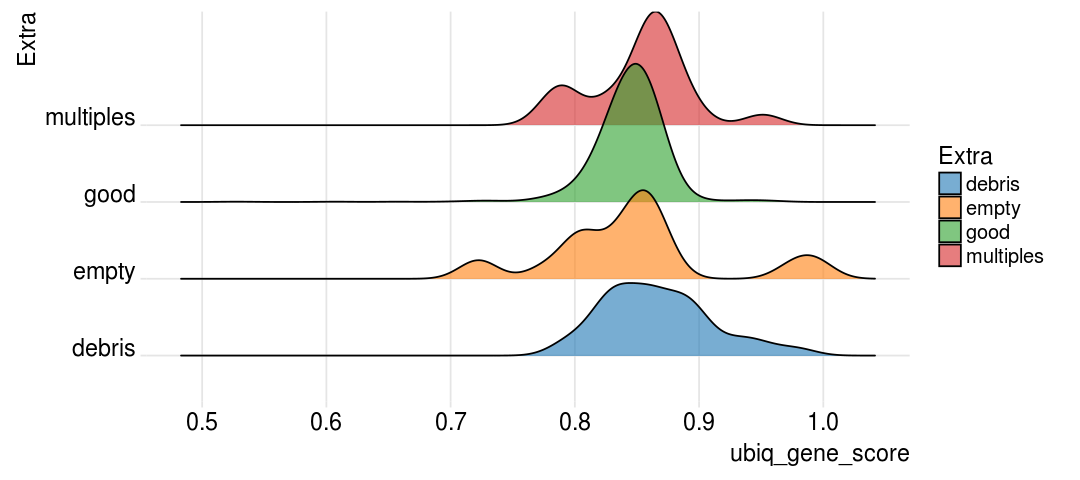

In [170]:
options(repr.plot.width=9, repr.plot.height=4)
bind_cols(pData(sce), as_data_frame(redDim(sce))) %>%
    ggplot(aes(x = ubiq_gene_score, y = Extra, fill = Extra)) +
        geom_joy(alpha = 0.6) + theme_joy() + scale_fill_tableau()

Picking joint bandwidth of 0.00333


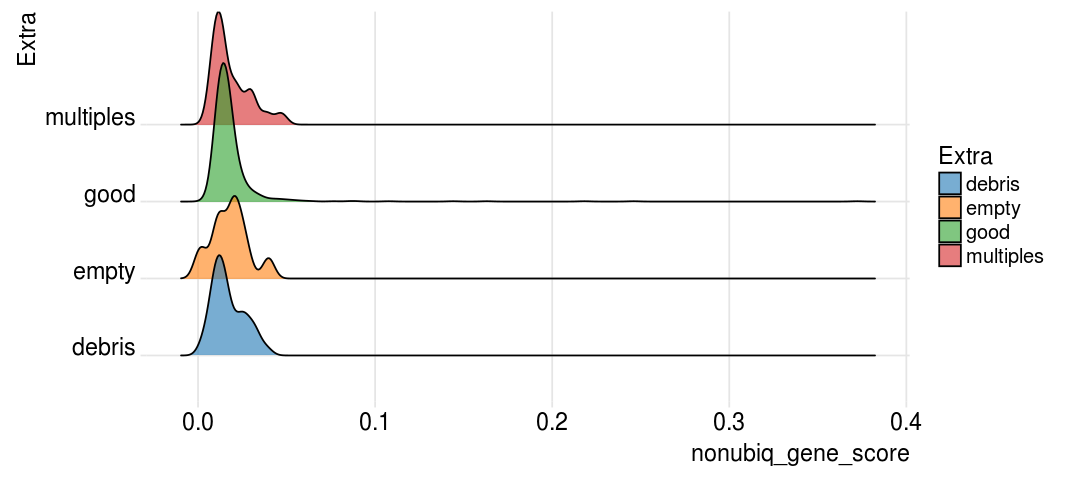

In [176]:
options(repr.plot.width=9, repr.plot.height=4)
bind_cols(pData(sce), as_data_frame(redDim(sce))) %>%
    ggplot(aes(x = nonubiq_gene_score, y = Extra, fill = Extra)) +
        geom_joy(alpha = 0.6) + theme_joy() + scale_fill_tableau()

Picking joint bandwidth of 0.181


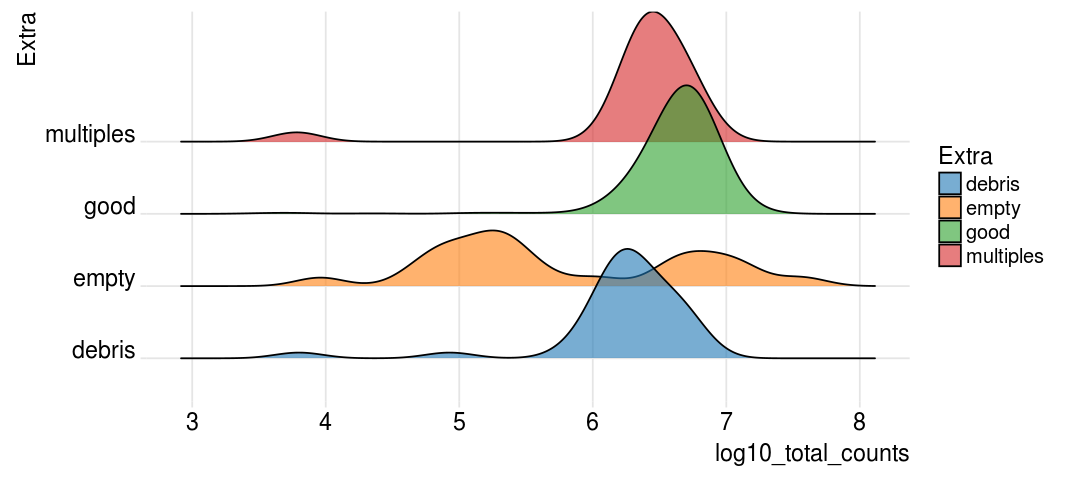

In [156]:
options(repr.plot.width=9, repr.plot.height=4)
bind_cols(pData(sce), as_data_frame(redDim(sce))) %>%
    ggplot(aes(x = log10_total_counts, y = Extra, fill = Extra)) +
        geom_joy(alpha = 0.6) + theme_joy() + scale_fill_tableau()

Picking joint bandwidth of 0.000597


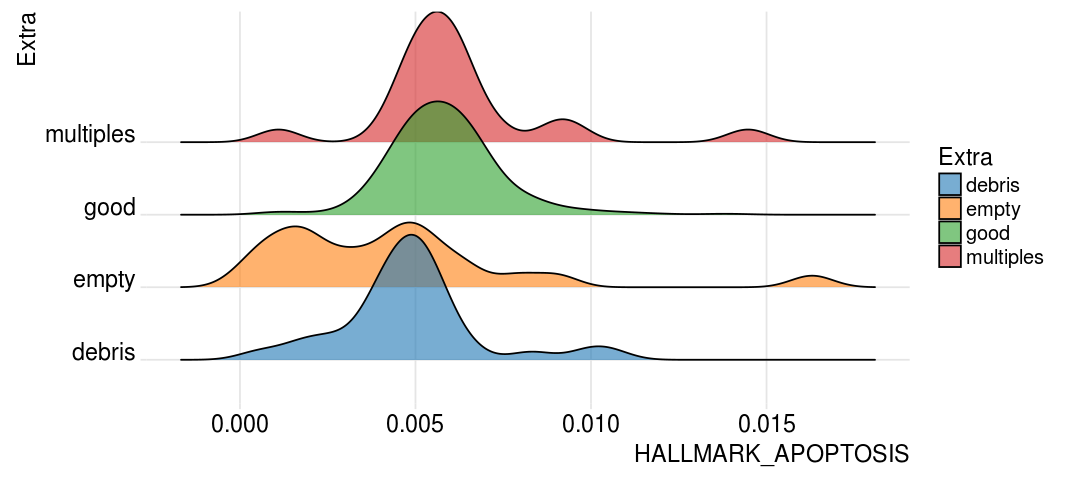

In [175]:
options(repr.plot.width=9, repr.plot.height=4)
ggplot(pData(sce), aes(x = HALLMARK_APOPTOSIS, y = Extra, fill = Extra)) +
    geom_joy(alpha = 0.6) + theme_joy() + scale_fill_tableau()

Picking joint bandwidth of 0.00255


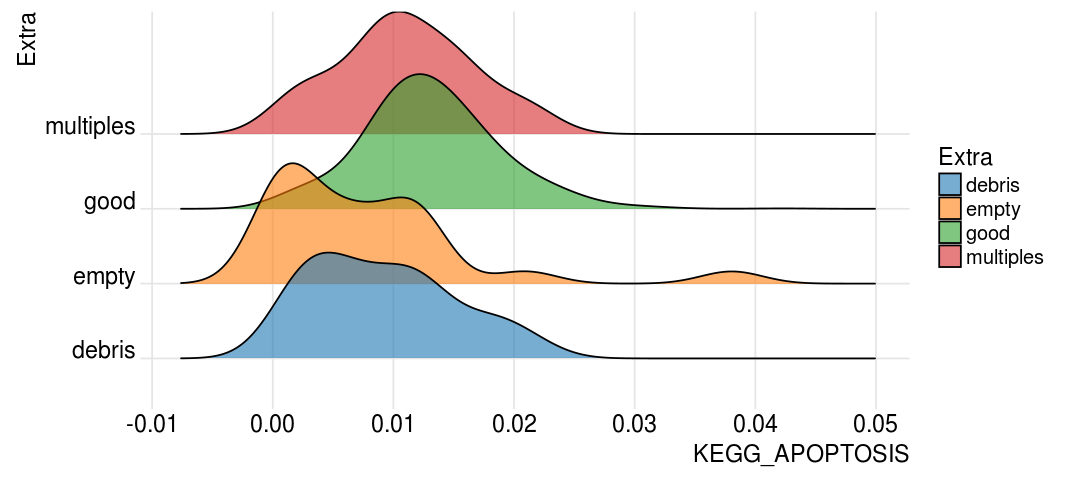

In [176]:
options(repr.plot.width=9, repr.plot.height=4)
ggplot(pData(sce), aes(x = KEGG_APOPTOSIS, y = Extra, fill = Extra)) +
    geom_joy(alpha = 0.6) + theme_joy() + scale_fill_tableau()

Picking joint bandwidth of 3e-04


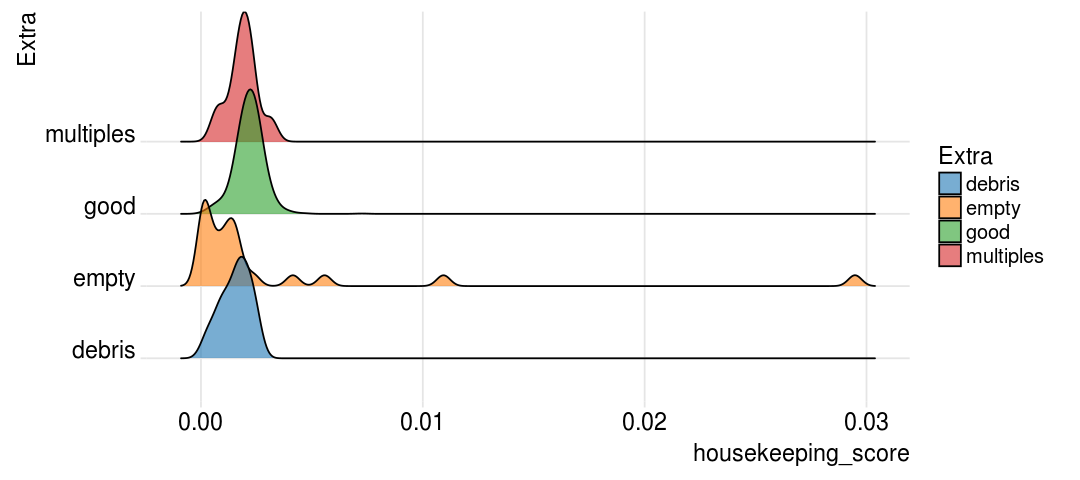

In [177]:
options(repr.plot.width=9, repr.plot.height=4)
ggplot(pData(sce), aes(x = housekeeping_score, y = Extra, fill = Extra)) +
    geom_joy(alpha = 0.6) + theme_joy() + scale_fill_tableau()

In [169]:
pdata_pca2$rotation[, 1:10]

PC1         PC2         PC3        
log10_total_counts                      0.34595923 -0.17717927  0.25844317
log10_total_features                    0.32908968 -0.04017225  0.34978388
size_factor                             0.25185379 -0.21732046 -0.49370402
pct_counts_feature_controls_ercc        0.17803099 -0.20177378 -0.60493192
n_detected_feature_controls_ercc        0.28367643  0.01229544  0.23954541
pct_counts_top_500_features            -0.28029605 -0.45723254  0.02611129
pct_counts_top_500_endogenous_features -0.28019549 -0.45742997  0.02565803
log10_counts_feature_controls_ercc      0.38962106 -0.13723432 -0.11752799
log10_counts_feature_controls           0.38962106 -0.13723432 -0.11752799
log10_counts_endogenous_features        0.34593321 -0.17714370  0.25855519
housekeeping_score                      0.02630439  0.27993326 -0.12236538
HALLMARK_APOPTOSIS                      0.06221446  0.41263443 -0.14723378
KEGG_APOPTOSIS                          0.10722706  0.37804987 -0.10640686
                                       PC4          PC5         PC6        
log10_total_counts                      0.159900662  0.30528536  0.03588083
log10_total_features                   -0.097031367 -0.18217268  0.09154985
size_factor                             0.124664394  0.13448646 -0.02188933
pct_counts_feature_controls_ercc       -0.177857811 -0.28383071  0.01663778
n_detected_feature_controls_ercc       -0.114822564 -0.50223868  0.06979121
pct_counts_top_500_features             0.175937829  0.14343475  0.09786101
pct_counts_top_500_endogenous_features  0.175875862  0.14330268  0.09787638
log10_counts_feature_controls_ercc      0.008018441  0.05793662  0.01051494
log10_counts_feature_controls           0.008018441  0.05793662  0.01051494
log10_counts_endogenous_features        0.159937478  0.30534791  0.03587524
housekeeping_score                      0.641785125 -0.19613996  0.66997839
HALLMARK_APOPTOSIS                     -0.390616406  0.57413334  0.36816220
KEGG_APOPTOSIS                          0.502586818  0.11646451 -0.61613736
                                       PC7         PC8         PC9        
log10_total_counts                     -0.07371982  0.03126202  0.10817073
log10_total_features                    0.07163113 -0.40848685 -0.72772318
size_factor                             0.02552305  0.60481425 -0.49157529
pct_counts_feature_controls_ercc        0.09480786 -0.43943097  0.07042676
n_detected_feature_controls_ercc        0.62327027  0.38462028  0.22887667
pct_counts_top_500_features             0.35493081 -0.12667726 -0.01464229
pct_counts_top_500_endogenous_features  0.35513101 -0.12674803 -0.01461472
log10_counts_feature_controls_ercc     -0.05081847 -0.14593008  0.26862446
log10_counts_feature_controls          -0.05081847 -0.14593008  0.26862446
log10_counts_endogenous_features       -0.07374106  0.03135326  0.10817289
housekeeping_score                     -0.05311871 -0.06092640  0.01357993
HALLMARK_APOPTOSIS                      0.42469531 -0.07253620 -0.02833155
KEGG_APOPTOSIS                          0.38137145 -0.20166472 -0.04788208
                                       PC10        
log10_total_counts                     -0.379405541
log10_total_features                    0.123209211
size_factor                             0.058248341
pct_counts_feature_controls_ercc       -0.492068633
n_detected_feature_controls_ercc       -0.053968978
pct_counts_top_500_features             0.090367422
pct_counts_top_500_endogenous_features  0.091261634
log10_counts_feature_controls_ercc      0.464737008
log10_counts_feature_controls           0.464737008
log10_counts_endogenous_features       -0.379319759
housekeeping_score                     -0.004904205
HALLMARK_APOPTOSIS                     -0.000669781
KEGG_APOPTOSIS                         -0.008364086

## PCA on genesets

In [148]:
sum((fData(sce)$hgnc_symbol %in% hallmark_genesets[["HALLMARK_APOPTOSIS"]]@geneIds))

[1] 153

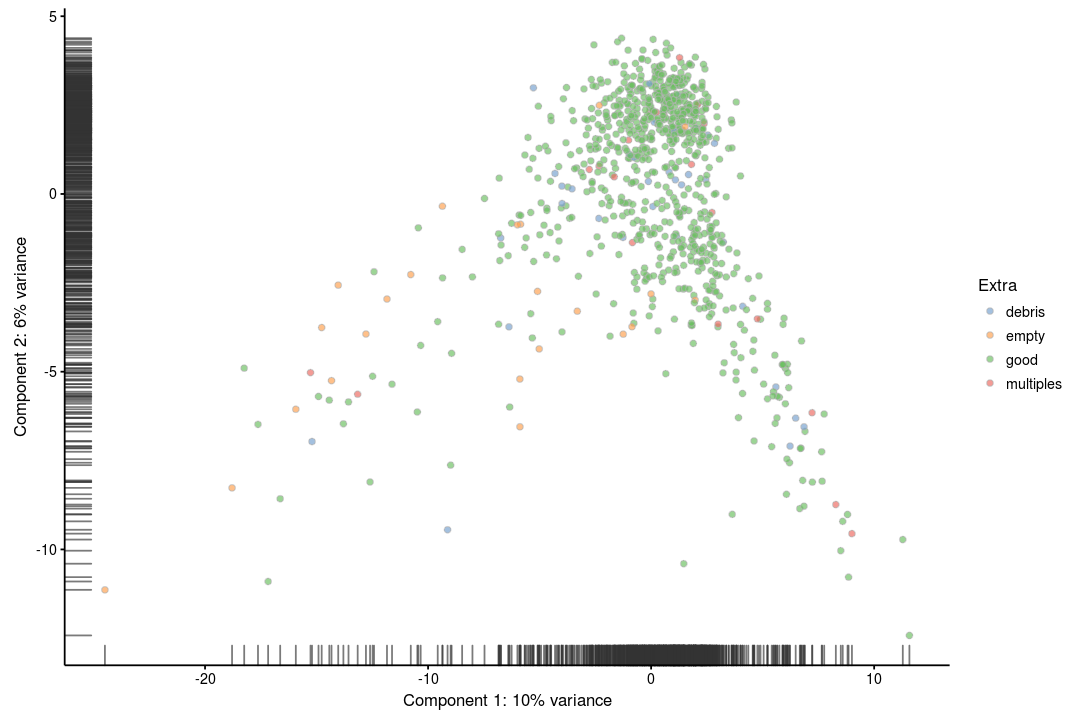

In [149]:
plotPCA(sce, colour_by = "Extra",
        feature_set = (fData(sce)$hgnc_symbol %in% hallmark_genesets[["HALLMARK_APOPTOSIS"]]@geneIds))

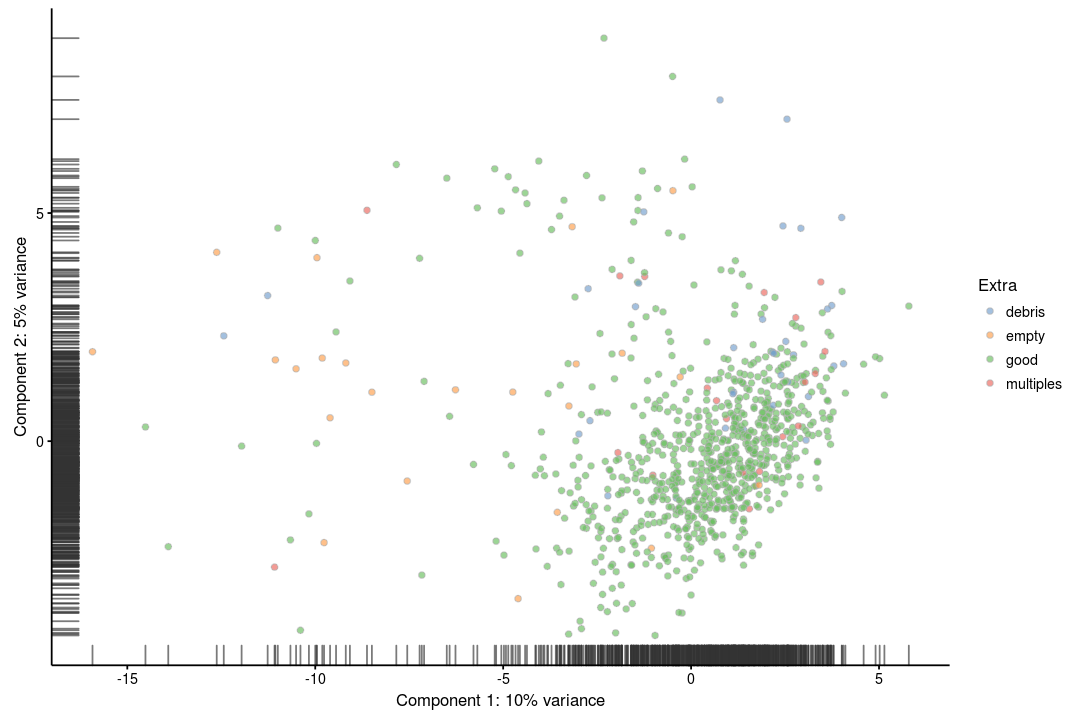

In [151]:
plotPCA(sce, colour_by = "Extra",
        feature_set = (fData(sce)$hgnc_symbol %in% kegg_genesets[["KEGG_APOPTOSIS"]]@geneIds))

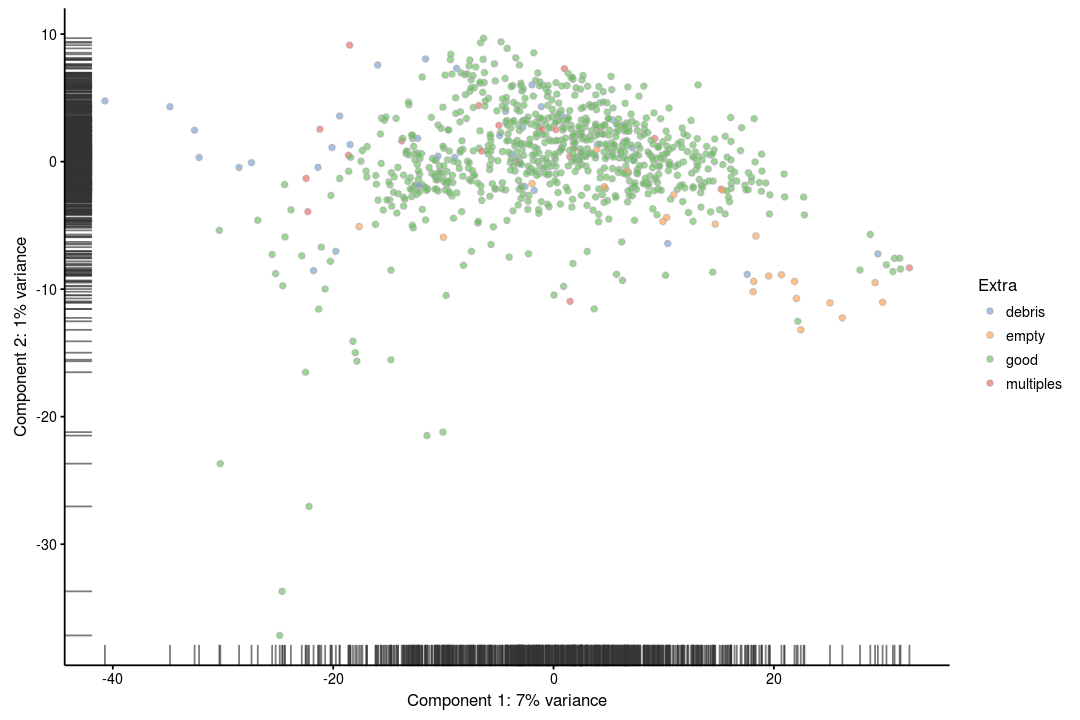

In [155]:
plotPCA(sce, colour_by = "Extra",
        feature_set = (featureNames(sce)[grepl("^RP", fData(sce)$mgi_symbol)]))

## Ambient gene analysis

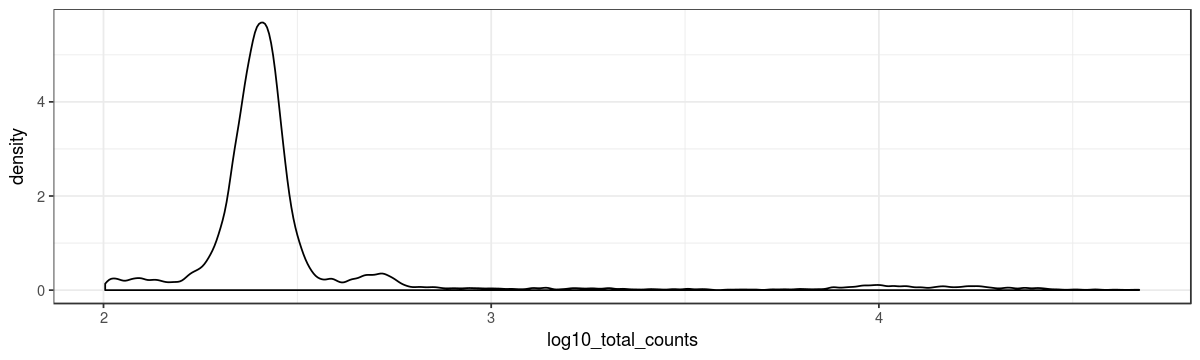

In [19]:
options(repr.plot.width = 10, repr.plot.height=3)
ggplot(pData(sce), aes(x = log10_total_counts)) +
    geom_density(alpha = 0.4) +
    theme_bw() + viridis::scale_color_viridis()

In [18]:
profile_ambient <- function(object, max_umis = 1000) {
    agg_counts <- rowSums(counts(object)[, object$total_counts < max_umis])
    agg_cpm <- agg_counts / sum(agg_counts)
    data_frame(agg_counts, agg_cpm, agg_exprs = log2(agg_cpm + 1))
}

In [39]:
ambient_profile_500 <- profile_ambient(sce, 500)
ambient_profile_1000 <- profile_ambient(sce, 1000)

In [41]:
table(ambient_profile_500[[1]] == 0)


FALSE  TRUE 
14291  3034 

In [42]:
table(ambient_profile_1000[[1]] == 0)


FALSE  TRUE 
14457  2868 

In [43]:
summary(ambient_profile_1000[["agg_cpm"]])

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 4.010e-07 4.011e-06 5.772e-05 2.085e-05 1.723e-02 

In [46]:
summary(ambient_profile_500[["agg_cpm"]])

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 4.360e-07 3.922e-06 5.772e-05 2.048e-05 1.724e-02 

In [44]:
sum(ambient_profile_500[[1]])

[1] 2294750

In [45]:
sum(ambient_profile_1000[[1]])

[1] 2493353

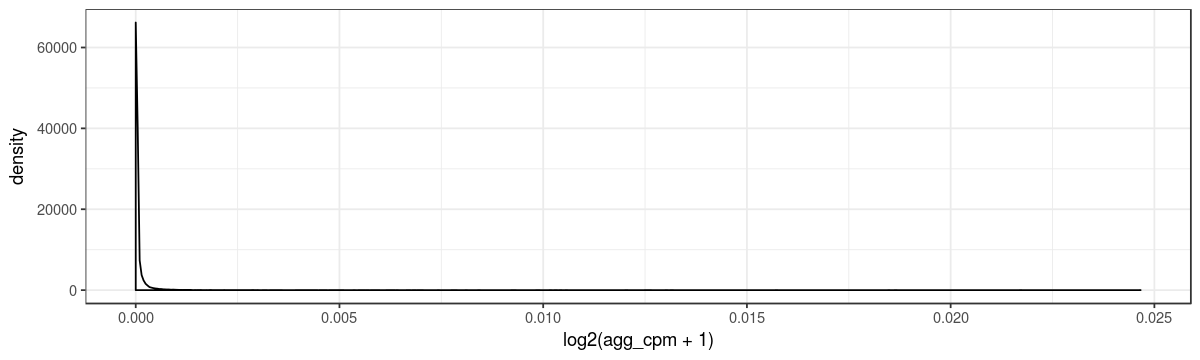

In [47]:
ggplot(ambient_profile_500, aes(x = log2(agg_cpm + 1))) +
    geom_density() + theme_bw()

In [48]:
sce_agg_amb <- sce

In [49]:
sce_agg_amb <- calculateQCMetrics(sce_agg_amb, 
                          feature_controls = list(
                              ambient = ambient_profile_500[[2]] > median(ambient_profile_500[[2]])))

In [56]:
meanvar_df <- data_frame(mean_exprs = rowMeans(exprs(sce)), var_exprs = rowVars(exprs(sce)))

`geom_smooth()` using method = 'gam'


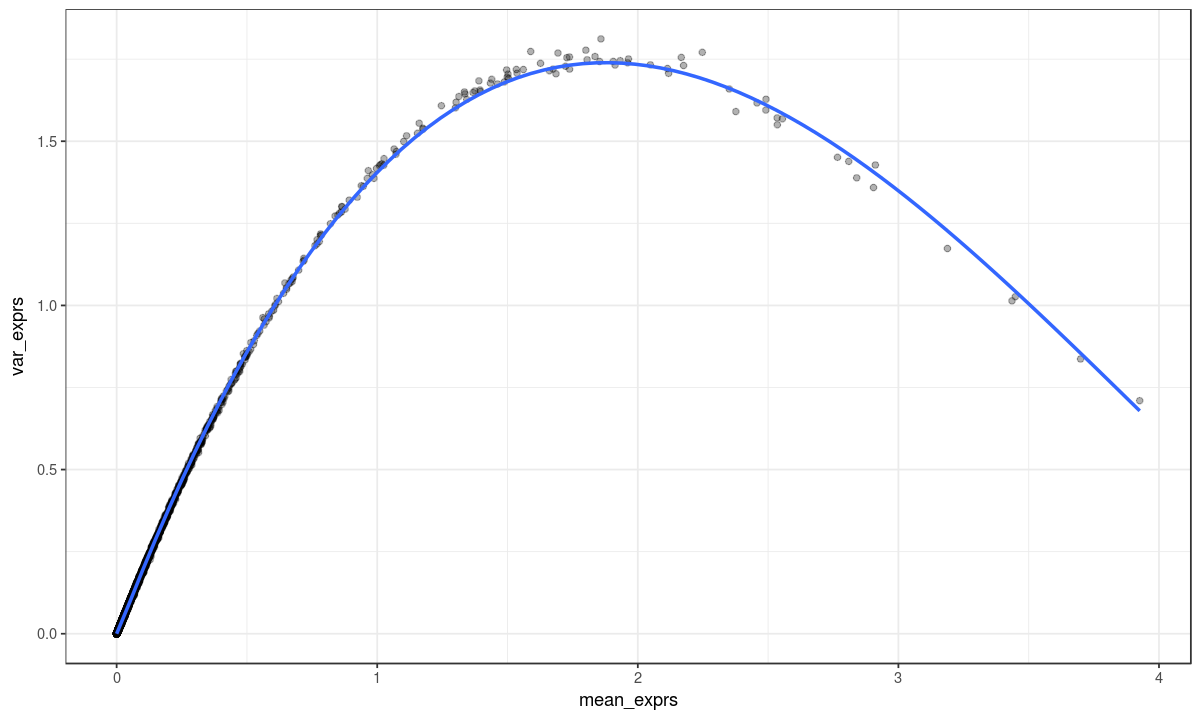

In [57]:
ggplot(meanvar_df, aes(x = mean_exprs, y = var_exprs)) +
    geom_point(alpha = 0.3) + geom_smooth() +
    theme_bw()

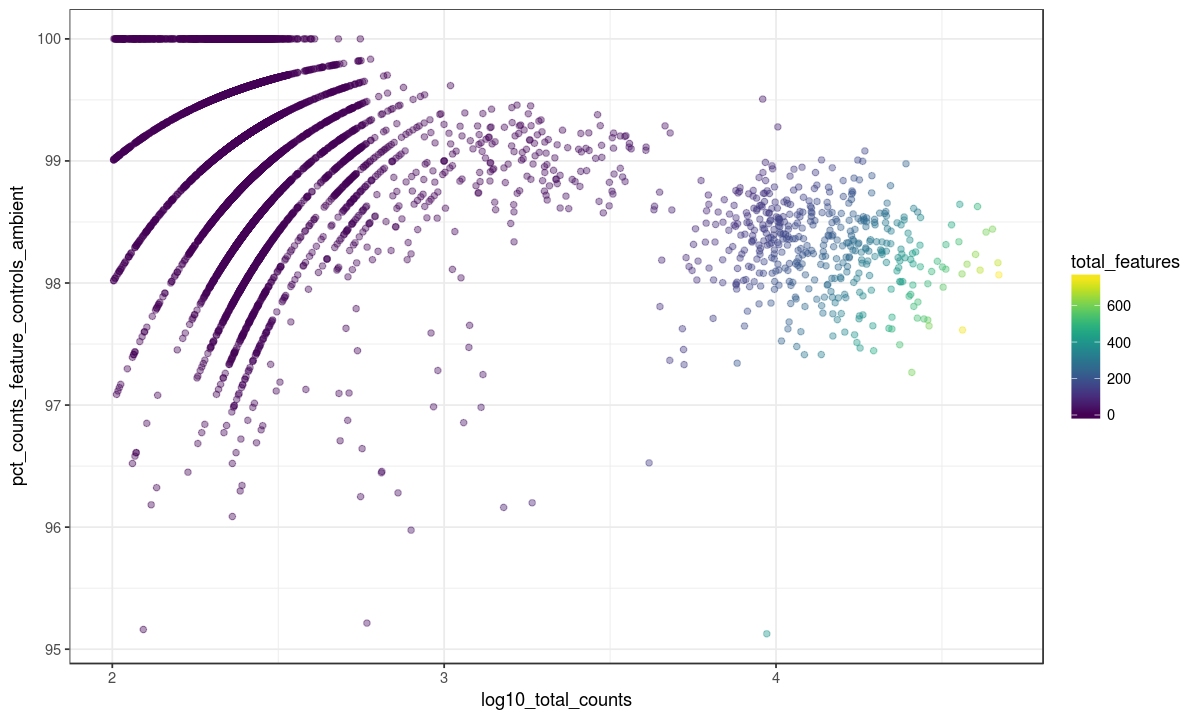

In [50]:
options(repr.plot.width = 10, repr.plot.height=6)
ggplot(pData(sce_agg_amb), aes(x = log10_total_counts, y = pct_counts_feature_controls_ambient, 
                               colour = total_features)) +
    geom_point(alpha = 0.4) +
    theme_bw() + viridis::scale_color_viridis()

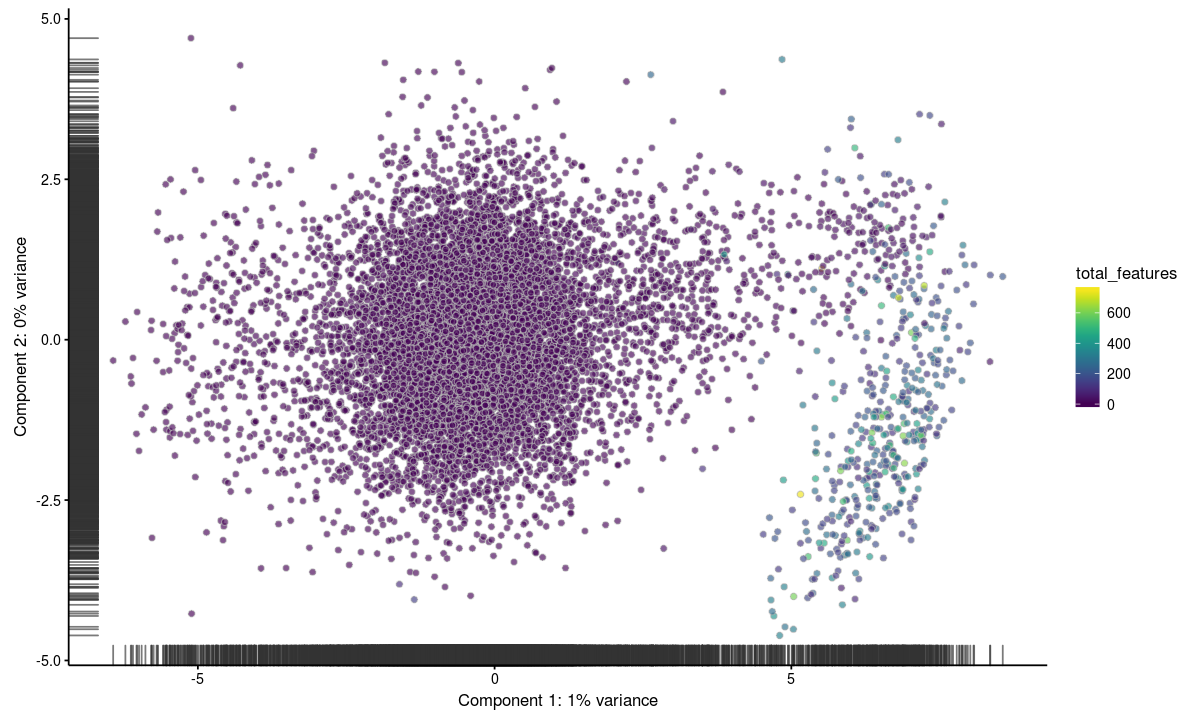

In [51]:
options(repr.plot.width = 10, repr.plot.height=6)
plotPCA(sce_agg_amb[fData(sce_agg_amb)$is_feature_control_ambient,], colour = "total_features")

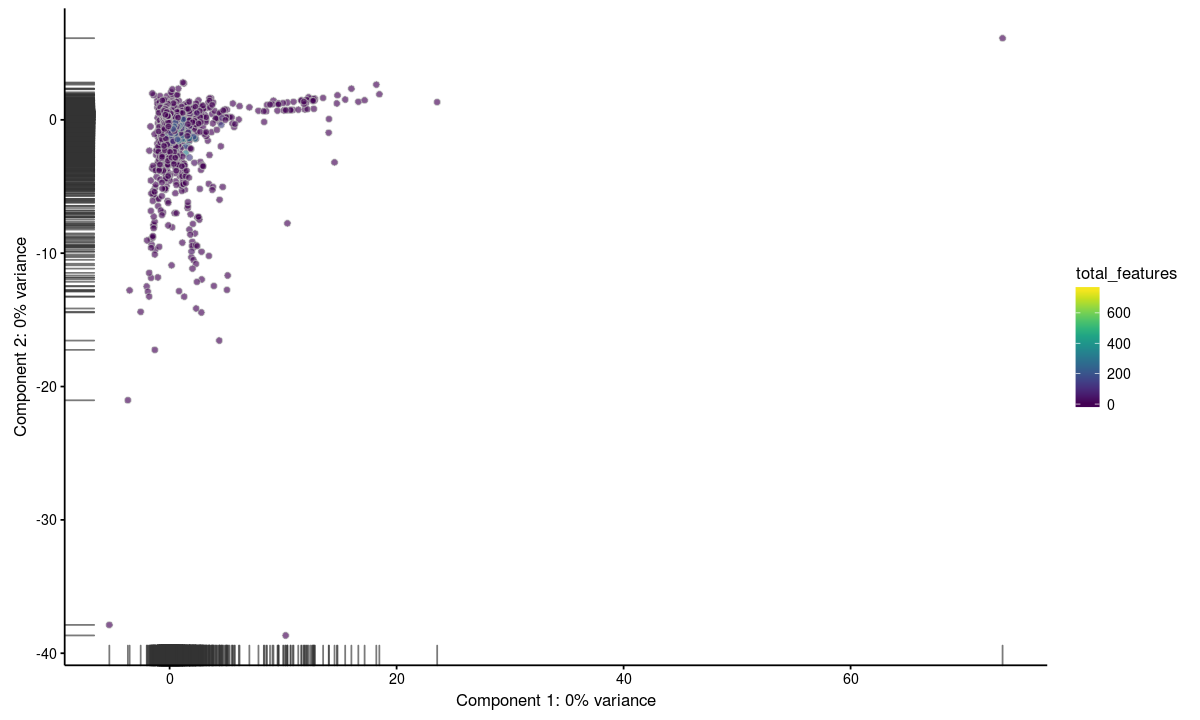

In [52]:
options(repr.plot.width = 10, repr.plot.height=6)
plotPCA(sce_agg_amb[!fData(sce_agg_amb)$is_feature_control_ambient,], colour = "total_features")

In [53]:
summary(colSums(counts(sce_agg_amb)[fData(sce_agg_amb)$is_feature_control_ambient,]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   99.0   227.0   254.0   911.9   284.0 46012.0 

In [54]:
summary(colSums(counts(sce_agg_amb)[!fData(sce_agg_amb)$is_feature_control_ambient,]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    2.00   13.69    4.00  907.00 

In [67]:
sce$gini_all_genes <- apply(exprs(sce), 2, Gini)
ubiq_genes <- featureNames(sce)[fData(sce)$n_cells_exprs > 2500]
nonubiq_genes <- featureNames(sce)[fData(sce)$n_cells_exprs < 2500]
sce$gini_ubiq_genes <- apply(exprs(sce)[ubiq_genes,], 2, Gini)
sce$gini_nonubiq_genes <- apply(exprs(sce)[nonubiq_genes,], 2, Gini)
sce$gini_ambient_genes_l1 <- apply(exprs(sce)[fData(sce)$ambient_gene_l1,], 2, Gini)
sce$gini_ambient_genes_l2 <- apply(exprs(sce)[fData(sce)$ambient_gene_l2,], 2, Gini)

## Covariance/distance analysis

In [ ]:
sce_1000 <- sce[fData(sce)$ambient_gene_l1, 1:1000]
d1 <- dist(as.matrix(t(exprs(sce_1000))))
mds1 <- cmdscale(d1, k = 3)
redDim(sce_1000) <- mds1
plotReducedDim(sce_1000, colour_by = "total_features")

In [ ]:
d2 <- dist(as.matrix(t(exprs(sce_1000))), method = "canberra")
mds2 <- cmdscale(d2, k = 3)
redDim(sce_1000) <- mds2
plotReducedDim(sce_1000, colour_by = "total_features")

In [ ]:
d3 <- dist(as.matrix(t(exprs(sce_1000))), method = "binary")
mds3 <- cmdscale(d3, k = 3)
redDim(sce_1000) <- mds3
plotReducedDim(sce_1000, colour_by = "total_features")

In [ ]:
sce_good <- sce[, sce$total_features > 1000 & sce$total_counts > 2000]
sce_bad <- sce[, sce$total_features < 1000 | sce$total_counts < 2000]
bad_profile_exprs <- matrixStats::rowMedians(exprs(sce_bad))
bad_profile_counts <- matrixStats::rowMedians(counts(sce_bad))

In [58]:
score1 <- cor(exprs(sce), log2(ambient_profile_500[[2]] + 1), method = "pearson")
score2 <- cor(exprs(sce), log2(ambient_profile_500[[2]] + 1), method = "spearman")


In [60]:
sce$bad_score_exprs_pears <- score1[, 1]
sce$bad_score_exprs_spear <- score2[, 1]

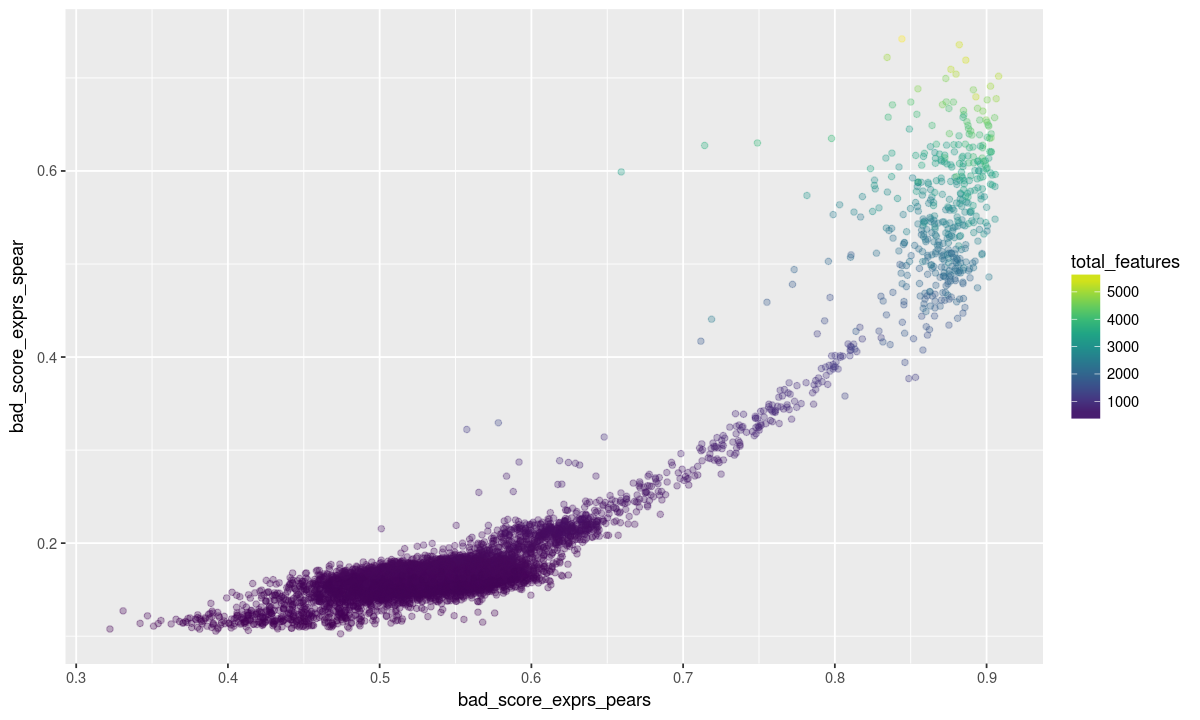

In [62]:
ggplot(pData(sce), aes(x = bad_score_exprs_pears, y = bad_score_exprs_spear, colour = total_features)) +
    geom_point(alpha = 0.3) + viridis::scale_color_viridis()

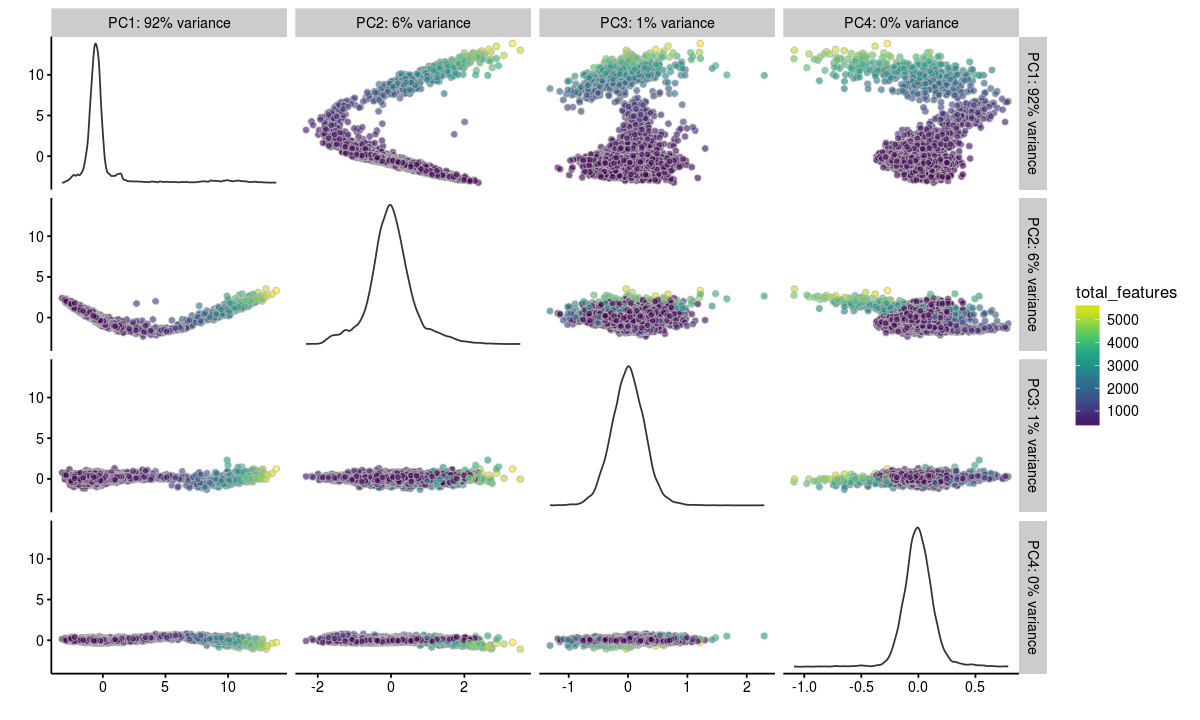

In [71]:
plotPCA(sce, ntop = 500, ncomponents = 4, colour_by = "total_features",
  exprs_values = "exprs", pca_data_input = "pdata",
  selected_variables = c("bad_score_exprs_pears", "bad_score_exprs_spear", 
                         "gini_ubiq_genes", "gini_nonubiq_genes", "gini_ambient_genes_l1", "gini_ambient_genes_l2"))

In [72]:
metrics_pca <- prcomp(pData(sce)[, c("bad_score_exprs_pears", "bad_score_exprs_spear", 
                         "gini_ubiq_genes", "gini_nonubiq_genes", "gini_ambient_genes_l1", "gini_ambient_genes_l2")])

In [74]:
metrics_pca$rotation

PC1        PC2        PC3         PC4        
bad_score_exprs_pears  0.5315044 -0.0483436 -0.84460976  0.04172732
bad_score_exprs_spear  0.5297232  0.5357279  0.28333357 -0.37212612
gini_ubiq_genes       -0.5406153  0.7428806 -0.37823343  0.09248829
gini_nonubiq_genes    -0.1432222 -0.2298833 -0.06037228  0.24874441
gini_ambient_genes_l1 -0.3098831 -0.2352089 -0.22436519 -0.88474472
gini_ambient_genes_l2 -0.1676048 -0.2249830 -0.09649536  0.08111654
                      PC5          PC6         
bad_score_exprs_pears -0.002593595  0.007236887
bad_score_exprs_spear  0.459304024  0.051700916
gini_ubiq_genes        0.063724496  0.013717068
gini_nonubiq_genes     0.591613849  0.714923441
gini_ambient_genes_l1  0.040041351  0.118037955
gini_ambient_genes_l2  0.658302377 -0.687050216

In [77]:
ggplot(pData(sce), aes(x = bad_score_exprs_spear, y = gini_ubiq_genes, colour = total_features)) +
    geom_point() + theme_bw() + viridis::scale_color_viridis()